# Overview

**Description**  
- In this notebook, I'll be showing my machine learning workflow for creating the sentiment analysis model used by this server
- The dataset used is Go-Emotions, a corpus of 58k carefully curated comments extracted from Reddit, with human annotations to 27 emotion categories or Neutral
- My work was done on kaggle at https://www.kaggle.com/code/leinadest/leinadest-social-media-sentiment-analysis

**Summary**
1. Ingest the Go-Emotions dataset to provide training and testing data for sentiment analysis
2. Initial EDA to see what the data looks like
3. Data cleaning
4. Feature engineering
5. EDA on new features
6. More feature engineering
7. Experiment with different vectorization methods, classifiers, and hyperparameters
8. Train and evaluate the best pipeline
9. Save pipeline

# Imports

In [1]:
# Built-in
import re
import warnings
import time
import os
import tarfile
import joblib

# Data
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Machine learning
import mlflow
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Natural-Language Processing
import spacy

# Cloud
from google.cloud import storage

# Setup

In [2]:
### CONFIGURATIONS ###

pd.set_option('display.max_colwidth', 1000)
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

### VISUAL HELPERS ###

def display_section(title, section_fn):
    display(HTML(f'<p style="font-size: 1.5rem">{title}</p>'))
    section_fn()
    display(HTML(f'<hr/>'))

def display_multiple(*dfs):
    df_divs = ''.join([f"<div>{df.to_html()}</div>" for df in dfs])
    display(HTML(
        f"<div style='display: flex; gap: 2rem'>{df_divs}</div>"
    ))

### DOWNLOADS

def get_stopwords():
    nlp = spacy.load("en_core_web_lg")
    return nlp.Defaults.stop_words

stopwords = get_stopwords()

# Ingest

In [3]:
ds_original = pd.concat([pd.read_csv('../data/goemotions_1.csv'), 
                         pd.read_csv('../data/goemotions_2.csv'), 
                         pd.read_csv('../data/goemotions_3.csv')])

display(ds_original.head())
display(ds_original.info())

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,">sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of ""grouping""",eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Falcon.",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
Index: 211225 entries, 0 to 71224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  confus

None

# EDA #1

**Goal**
- Make sense of the Go-Emotions dataset
- Decide which sentiments to target

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
1,">sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of ""grouping""",eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
62,Oi us cancers don’t want him either! We respectfully pass his birthday to April,ee0ai3t,schwiftypants39,Justfuckmyshitup,t3_afgkgb,t1_edzkirq,1.547418e+09,22,True,0,...,0,0,0,0,0,0,0,0,0,0
195,I unfortunately can not afford a lawyer. Luckily the only thing that we shared is our daughter,ed0rtl7,Renissancelady,Divorce,t3_abjqns,t1_ed0rm5b,1.546364e+09,12,True,0,...,0,0,0,0,0,0,0,0,0,0
262,OMG THOSE TINY SHOES! *desire to boop snoot intensifies*,eei8tja,I_69_WITH_DOGS,chicago,t3_ahu4m4,t3_ahu4m4,1.547963e+09,61,True,0,...,0,0,0,0,0,0,0,0,0,0
264,"I would pay money for [NAME] to not be my nurse. She will probably ""accudentally"" squeeze my nuts. Crazy bitch.",ee8zjas,-Azwel-,SoulCalibur,t3_agt3qw,t3_agt3qw,1.547697e+09,22,True,0,...,0,0,0,0,0,0,0,0,0,0


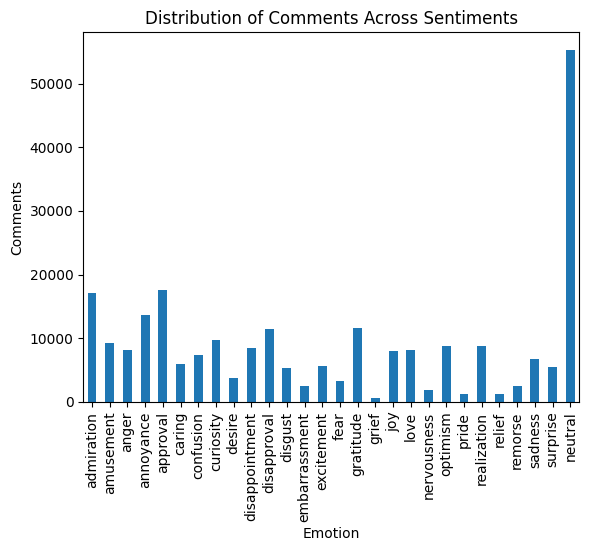

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
69734,"""If you don't wear BROWN AND ORANGE...YOU DON'T MATTER!"" We need a tshirt with that on it asap!",ee3fxil,pj7140,Browns,t3_afy4f0,t3_afy4f0,1.547522e+09,1,False,0,...,0,0,0,0,0,0,0,0,0,1
13034,"""If you don't wear BROWN AND ORANGE...YOU DON'T MATTER!"" We need a tshirt with that on it asap!",ee3fxil,pj7140,Browns,t3_afy4f0,t3_afy4f0,1.547522e+09,72,False,0,...,0,0,0,0,0,0,0,0,0,0
59223,"""If you don't wear BROWN AND ORANGE...YOU DON'T MATTER!"" We need a tshirt with that on it asap!",ee3fxil,pj7140,Browns,t3_afy4f0,t3_afy4f0,1.547522e+09,22,False,0,...,0,0,1,0,0,0,0,0,0,0
24588,"""If you don't wear BROWN AND ORANGE...YOU DON'T MATTER!"" We need a tshirt with that on it asap!",ee3fxil,pj7140,Browns,t3_afy4f0,t3_afy4f0,1.547522e+09,40,False,0,...,0,0,0,0,0,0,0,0,0,0
49838,"""What do Scottish people look like?"" How I would love to have been there to take a swing at that softball.",ee7cu0z,Cheezeburger_Picnic,Scotland,t3_agmpx9,t3_agmpx9,1.547658e+09,4,False,0,...,0,0,0,0,0,0,0,0,0,0


Artificial tokens: {'[T]', '[NAME]', '[RELIGION]', '[ALL]'}


["I appreciate it, that's good to know. I hope I'll have to apply that knowledge one day",
 "Pretty much every Punjabi dude I've met.",
 'Lots, play store or apple store vpn. Nord is good',
 "nice!! I'll try this one",
 'She’s like a kewpie doll with them. Precious.']

["That's crazy; I went to a super [RELIGION] high school and I think I can remember 2 girls the entire 4 years that became teen moms.",
 "that's adorable asf",
 '"Sponge Blurb Pubs Quaw Haha GURR ha AAa!" finale is too real',
 'I just got a shirt made that says “I can’t have kids my dog is allergic”',
 'Funny, the right only seems to say this about women and people of color 🤔🤔🤔']

['"Oh, how DARE you discuss the disgustingly unhealthy and dangerous lifestyle I pursue!" /s',
 'Press fucken charges the moment they use your info.',
 'Shut up 15 year-old',
 'I thought it was very good. The guy was one sick bastard that’s for sure.',
 'Lol. Build your own or make some tweaks to the printer.']

["For extra measure tape it right by your crotch so she can't take it for sexual assault reasons",
 'Go troll elsewhere. This woman needs support, not crass questions.',
 "Just rumors online, it most likely won't happen",
 'Good old guardian refusing to accept that [NAME] is stauncly anti-EU and anti-Brussels',
 "Do you not give your snowmen brooms? I feel like that's a thing people do"]

['If there’s a pattern, yes.',
 "I didn't like the family ending but I liked the Atlantis ending especially as we know we are going to see more of it in DLC2.",
 'Political affiliations has only little correlation to individual intellectual ability',
 'Looks like a classic subluxation; that guy needs to get to the chiropractor!',
 'Thank you for being willing to learn']

['Yup, not anymore. Keep your blood sugar up! It really helps and DRINK water...',
 'Gotta protect’em!',
 'Let go or you will be dragged',
 "No we're getting Kinsler and be happy with it",
 'Because [NAME] had a foot injury that I think he sustained at practice for the second half of the year.']

['What does Clemson give pride stickers for? Snaps played?',
 "Because the content creators don't deserve to be paid, your seconds spent listening to ads are too valuable!",
 ">not a cure-all. Since we don't have such a thing, is this not the next best option?",
 'Oh whoops, I misread the original comment',
 'Not knowing what it is, for one thing.']

["Now I'm wondering on what I've been missing out. Again thank you for this.",
 "Because the content creators don't deserve to be paid, your seconds spent listening to ads are too valuable!",
 '"Oh, how DARE you discuss the disgustingly unhealthy and dangerous lifestyle I pursue!" /s',
 'Damn. That’s profound. Did you graduate from Harvard?',
 'The service made it 20 years ago (1999, yeah ikr 1999 was 20 YEARS AGO?) ']

['I wanna die!',
 "All the signs, except his username, seemed legit. I also clicked. Now I just want to forget all about what I've just seen...",
 '[NAME]: "I wish I won\'t get robbed of a victory again" [one finger of the monkeys paw curls]',
 '😭 I wanted her to be on the top 4; now we’ve heard plenty of times [NAME] mentioned so pretty sure ain’t gonna happen',
 "I'm really worried :( I sent a DM to them, I hope they will be okay... "]

["I wanted to downvote this, but it's not your fault homie.",
 'That is odd.',
 'Dark and funny, but not really nice guy. He has yet to call the dead girls whores for declining to sleep with him. ',
 "Honestly at this point I don't think there's anything that will make me feel better. Maybe down the road, but right now nothing is helping. ",
 "I can't believe he got it while getting man-handled by two players!!"]

["He isn't as big, but he's still quite popular. I've heard the same thing about his content. Never watched him much.",
 'I can\'t stand [NAME]. Especially since her "tatooing my own face" video. ',
 'There has to be some repercussions for this judge, right? Considering the crimes, that bail seems incredibly low...',
 'Press fucken charges the moment they use your info.',
 '>Did you just call me a liar? Sick reference.']

['That is odd.',
 "So happy for [NAME]. So sad he's not here. Imagine this team with [NAME] instead of [NAME]. Ugh.",
 'Dark and funny, but not really nice guy. He has yet to call the dead girls whores for declining to sleep with him. ',
 '"Oh, how DARE you discuss the disgustingly unhealthy and dangerous lifestyle I pursue!" /s',
 'Hypocritical is pot calling the kettle genocide']

['I don’t even try to make shots like this myself. So I gotta watch other people make them.',
 "Am I the only INTP here who cared about deadlines. It's how I got so good at crunch time and working last minute.",
 'Of course he will lie cheat and steal to make him self relevant to the public. Horrible person.',
 'He’s been going to a restaurant for 40 years and forgot what it looked like and where it was.. uh huh.',
 'Awkwardly remembering all of those promises I made mid-panic attack...']

['"Seeeee! We have one of them coloureds too!"',
 'Be ready to Experience Canes Hockey',
 "Great! Can't wait :)",
 'Cant wait to hear a hot take from the second dumbest people who ever loved ([NAME] ots the first if you are asking)',
 'Especially with the way they got rid of him... no real fanfare at all...']

['Yes. One of her fingers is getting a sore on it and there’s concern it may push her into needing braces.',
 'I watched a really bad horror movie she starred in but I think it predated VPR.',
 'oh my [NAME]. it was hurting my brain. i only saw the disappearing boot and thought i was missing something.',
 'NEXT TIME! ON THE CURSE OF OAK ISLAND!',
 'Yeah it’s not like I want my cat to lick me in a sexual way that’s just weird.']

['Right? Considering it’s such an important document, I should know the damned thing backwards and forwards... thanks again for the help!',
 "I appreciate it, that's good to know. I hope I'll have to apply that knowledge one day",
 "Now I'm wondering on what I've been missing out. Again thank you for this.",
 'I’m glad he’s okay but I’m even gladder it’s not that same gif of the guy ski/parachuting down a mountain',
 'Thanks for the info mate gonna watch out next time']

['Is he dead now from a tragic drowning accident? Asking for a friend.',
 'Drunk and crying in bed with my pets. :|',
 'that most of the fandom does not get that reference is depressing',
 'Hugs. We put our sweet lady kitty to sleep one year ago tomorrow.',
 'Some rambling paragraphs about what a waste I am and how sorry I am to be a disappointment to those around me and that sort.']

["So happy for [NAME]. So sad he's not here. Imagine this team with [NAME] instead of [NAME]. Ugh.",
 "By far the coolest thing I've seen on this thread yet",
 'Sending love and strength vibes <3',
 'Me too! First time in a couple of years!',
 'Which totally makes it less funny for a person like me who has never seen this before, and laughed. ']

['Man I love reddit.',
 'I just came home, what the fuck is this lineup? I love you [NAME] you mad bastard !!!',
 'I love this woman.',
 'This is kinda cute',
 "You're both wrong NBA is an initialism, can't be pronounced as a word. Oh man I love reddit"]

["Honestly at this point I don't think there's anything that will make me feel better. Maybe down the road, but right now nothing is helping. ",
 'oh my [NAME]. it was hurting my brain. i only saw the disappearing boot and thought i was missing something.',
 "Jfc, that's depressing.",
 'Yeah it’s not like I want my cat to lick me in a sexual way that’s just weird.',
 "Oh gosh that's no good! Perhaps the other options are better places to start"]

['"You may die, but it\'s a sacrifice I\'m willing to make"',
 'Sending love and strength vibes <3',
 'Started feeling smug about my short showers but then remembered just how small my water heater is.',
 "That's if you make the smallest payments possible, but if you just need to float a payment, then they will work. ",
 'Great for him to admit it. Not many people are that humble']

["I bought the double barrel and fully upgraded it and now it's one of my favorite guns.",
 '[NAME] did a photo shoot with the first presidency. Hilarious',
 "You're such a good troll. Good job! Way to really get into that part. You nailed it!",
 "At least you went out! For what it's worth, I definitely would have gone out with you if you were near me.",
 '18 still seems too young soooo.....']

['Well then I’d say you have a pretty good chance if it’s any girl lol',
 'Oh whoops, I misread the original comment',
 "Honestly at this point I don't think there's anything that will make me feel better. Maybe down the road, but right now nothing is helping. ",
 'Yeah, I read that the first time. Nobody is forcing you, other than yourself.',
 'This is why you play runescape as a kid, it teaches how to trust no one that offers free rune plate trimming']

['I’m glad I had a few margaritas before I read this',
 'Maybe [NAME] needs to have a Big Mac meal and relax.',
 'The positive side to this is i get to relive the same emotions that I felt losing my virginity....ever few months.',
 'Thanks man, I managed to feel better by letting loose with some music - definitely a *much* better way to pull out of a dive. ',
 "I've had a crown and bracelets made for me with old ad. Glad I'm not alone"]

['Na. Rediting my post. Sorry for the ignorance.',
 'Pity. I had some decent lunches there, but never went there at night.',
 'Then I’m sorry but this game really isn’t for you. Progression like that would ruin the base of what this game is.',
 '*and, sorry for the spelling mistake',
 'Sorry just seemed like you were trying to make it a [NAME] thing']

['That game hurt.',
 "So happy for [NAME]. So sad he's not here. Imagine this team with [NAME] instead of [NAME]. Ugh.",
 "Makes me sad I'll never be with a beautiful woman.",
 '>The ABC’s hard-hitting investigation :/ Such a sad article.',
 "Im 13 I can't get a job.."]

['Ironic. He could save others from secrecy-enabled corruption, but not himself.',
 'shockingly close to reality.',
 'Omg lala a housewife I can’t even imagine!',
 'People who hate [NAME] really really hate him. It’s quite fascinating.',
 "Something's wrong. The top post on r/conspiracy isn't completely anti-conspiracy? Wow, feels weird. /s(?)"]

["You do right, if you don't care then fuck 'em!",
 '[NAME] was nowhere near them, he was by the Falcon. ',
 "I have, and now that you mention it, I think that's what triggered my nostalgia. ",
 "BUT IT'S HER TURN! /s",
 'Build a wall? /jk']

In [4]:
sentiments = ['admiration', 'amusement', 'anger', 'annoyance', 
              'approval', 'caring', 'confusion', 'curiosity', 
              'desire', 'disappointment', 'disapproval', 'disgust',
              'embarrassment', 'excitement', 'fear', 'gratitude', 
              'grief', 'joy', 'love', 'nervousness', 'optimism', 
              'pride', 'realization', 'relief', 'remorse', 'sadness', 
              'surprise', 'neutral']

def target_section():
    # Display rows with missing label
    display(HTML(f'<strong>Missing Labels</strong>'))
    ds_unlabeled = ds_original.loc[ds_original[sentiments].sum(axis=1) == 0]
    display(ds_unlabeled.head())
    
    # Barplot to visualize distribution of sentiments
    ds_original[sentiments].sum().plot(kind='bar')
    plt.title('Distribution of Comments Across Sentiments')
    plt.xlabel('Emotion')
    plt.ylabel('Comments')
    plt.show()

def text_section():
    display(HTML(f'<strong>Duplicate Comments</strong>'))
    duplicate_comments = ds_original.loc[
        ds_original.duplicated(subset=['text'])
    ]
    display(duplicate_comments.sort_values(by='text').head())

    # Print tokens made from modifications to the comments
    tokens = set()
    for comment in ds_original['text'].to_list():
        token_pattern = r'\[([A-Z]+)\]'
        token_matches = re.search(token_pattern, comment)
        if token_matches:
            tokens.add(token_matches[0])
    print('Artificial tokens:', tokens)
    
    # Display example comments of each sentiment
    for sentiment in sentiments:
        sentiment_comments = ds_original['text'] \
            .loc[ds_original[sentiment] == 1] \
            .head() \
            .to_list()
        display(HTML(f'<strong>{sentiment.capitalize()}</strong>'), 
                sentiment_comments)

display_section('TARGET', target_section)
display_section('TEXT VISUALIZATIONS', text_section)

 ### Analysis

- Examples labeled "example_very_unclear" are not labeled with sentiment
- There are examples with duplicate comments and have inconsistent sentiment labels
- Artificial tokens from data processing: {\'[T]\', \'[ALL]\', \'[NAME]\', \'[RELIGION]\'}
- Sentiments have a hierarchy such that sentiments 'desire' and 'caring' are extensions of other sentiments such as 'joy', 'sadness', or 'anger'
- There are abbreviations, slang, and textual symbols which can be preprocessed
- Many sentiments share similarities such as "anger" and "annoyance"
- The frequencies of emotions vary a lot, making this dataset highly imbalanced

### Conclusion

- Drop examples labeled "example_very_unclear" and examples that are duplicates 
- Drop examples with labeled 'desire' or 'caring' as I'm interested in more fundamental emotions for my sentiment analysis task
- Create a preprocessor that translates abbreviations, slang, and symbols
- Group sentiments into five emotional categories: happy, sad, angry, scared, neutral
- Undersampling, oversampling, or model-based methods are common approaches to imbalanced datasets
    - For simplicity and convenience's sake I'll be using model-based methods

# Data Cleaning

**Goal**
- Drop examples labeled "example_very_unclear" as they aren't sentiment-labeled
- Drop examples with duplicate comments as they can add bias to the same sentiment and cause confusion with inconsistent sentiments
- Group sentiments into more fundamental emotions

Shape: (55133, 2)
Columns: ['text', 'emotion']
Missing values: 0
Duplicate comments: 0


,Distribution Numbers
emotion,
neutral,26226
happy,15722
angry,8949
sad,3301
scared,935


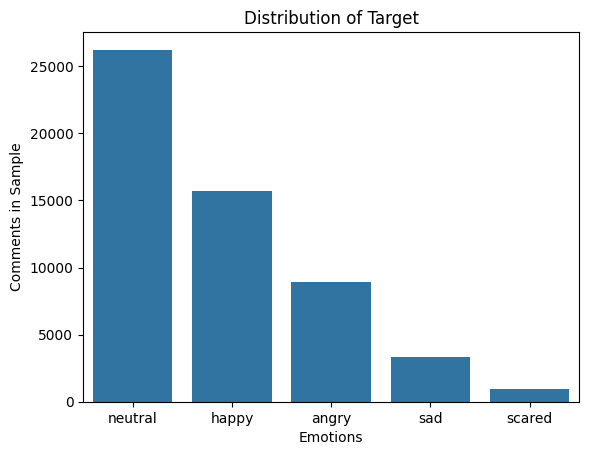

In [5]:
ds = ds_original.copy()

# Drop unclear examples and duplicate comments
ds = ds.loc[~ds_original['example_very_unclear']]
ds = ds.loc[~ds.duplicated(subset=['text'])]

# Drop irrelevant columns
ds.drop(['id', 'author', 'subreddit', 'link_id', 'parent_id', 
         'created_utc', 'rater_id', 'example_very_unclear'], 
        axis=1, inplace=True)

# Drop comments labeled "caring" or "desire"
ds = ds.loc[(ds['caring'] == 0) & (ds['desire'] == 0)]
ds.reset_index(drop=True)  # Fix index after dropped rows

# Organize sentiments into 6 categories
emotions = {
    'happy': ['admiration', 'amusement', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief'],
    'sad': ['sadness', 'grief', 'disappointment', 'remorse'],
    'angry': ['anger', 'annoyance', 'disapproval', 'disgust', 'embarrassment'],
    'scared': ['fear', 'nervousness'],
    'neutral': ['neutral', 'curiosity', 'approval', 'confusion', 'surprise', 'realization']
}

# Map each sentiment to its emotion category
sentiment_mappings = {
    sentiment: emotion 
    for emotion, sentiments in emotions.items()
    for sentiment in sentiments
}

# Compile one-hot encoded emotions into one categorical column
emotion_col = ds[sentiments].idxmax(axis=1) \
                            .map(sentiment_mappings)
emotion_col.name = 'emotion'

# Replace sentiments with new emotion label
ds = pd.concat([ds.drop(sentiments, axis=1), 
                emotion_col], axis=1)

# Display results
def ds_section():
    print('Shape:', ds.shape)
    print('Columns:', ds.columns.to_list())
    print('Missing values:', ds.isna().sum().sum())
    print('Duplicate comments:', ds.duplicated(subset=['text']).sum())

def target_section():
    distribution_df = ds['emotion'].value_counts().to_frame('Distribution Numbers')
    emotion_distribution = ds['emotion'].value_counts()
    display(emotion_distribution.to_frame('Distribution Numbers'))
    sns.barplot(x=emotion_distribution.index, y=emotion_distribution)
    plt.title('Distribution of Target')
    plt.xlabel('Emotions')
    plt.ylabel('Comments in Sample')
    plt.show()

display_section('DATASET RESULTS', ds_section)
display_section('TARGET RESULTS', target_section)

# Feature Engineering

In [6]:
ds['comment_length'] = ds['text'].apply(len)

ds['exclamation_mark_count'] = ds['text'].apply(
    lambda comment: comment.count('!')
)

ds['question_mark_count'] = ds['text'].apply(
    lambda comment: comment.count('?')
)

ds['period_count'] = ds['text'].apply(
    lambda comment: comment.count('.')
)

ds['double_dot_count'] = ds['text'].apply(
    lambda comment: comment.count('..')
)

ds['quotation_count'] = ds['text'].apply(
    lambda comment: comment.count('"')
)

def remove_artifacts(comment):
    artifacts = {'[T]', '[ALL]', '[NAME]', '[RELIGION]'}
    for artifact in artifacts:
        comment = comment.replace(artifact, '')
    return comment

ds['uppercase_count'] = ds['text'].apply(
    lambda comment: sum(1 for c in remove_artifacts(comment) if c.isupper())
)

def count_double_uppercase(comment):
    clean_comment = remove_artifacts(comment)
    return sum(1 for i in range(len(clean_comment)-1) if clean_comment[i].isupper() and clean_comment[i+1].isupper())

ds['double_uppercase_count'] = ds['text'].apply(count_double_uppercase)

ds.head()

,text,emotion,comment_length,exclamation_mark_count,question_mark_count,period_count,double_dot_count,quotation_count,uppercase_count,double_uppercase_count
0,That game hurt.,sad,15,0,0,1,0,0,1,0
2,"You do right, if you don't care then fuck 'em!",neutral,46,1,0,0,0,0,1,0
3,Man I love reddit.,happy,18,0,0,1,0,0,2,0
4,"[NAME] was nowhere near them, he was by the Falcon.",neutral,52,0,0,1,0,0,1,0
5,"Right? Considering it’s such an important document, I should know the damned thing backwards and forwards... thanks again for the help!",happy,135,1,1,3,1,0,3,0


# EDA on Comment Length

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,8949.0,73.017767,36.546680,4.0,43.0,71.0,100.0,188.0
happy,15722.0,64.652462,35.689229,5.0,35.0,61.0,90.0,703.0
neutral,26226.0,69.359109,36.943121,2.0,39.0,66.0,97.0,542.0
sad,3301.0,71.481066,35.447178,5.0,42.0,69.0,99.0,180.0
scared,935.0,73.572193,36.470675,8.0,42.0,74.0,102.0,170.0


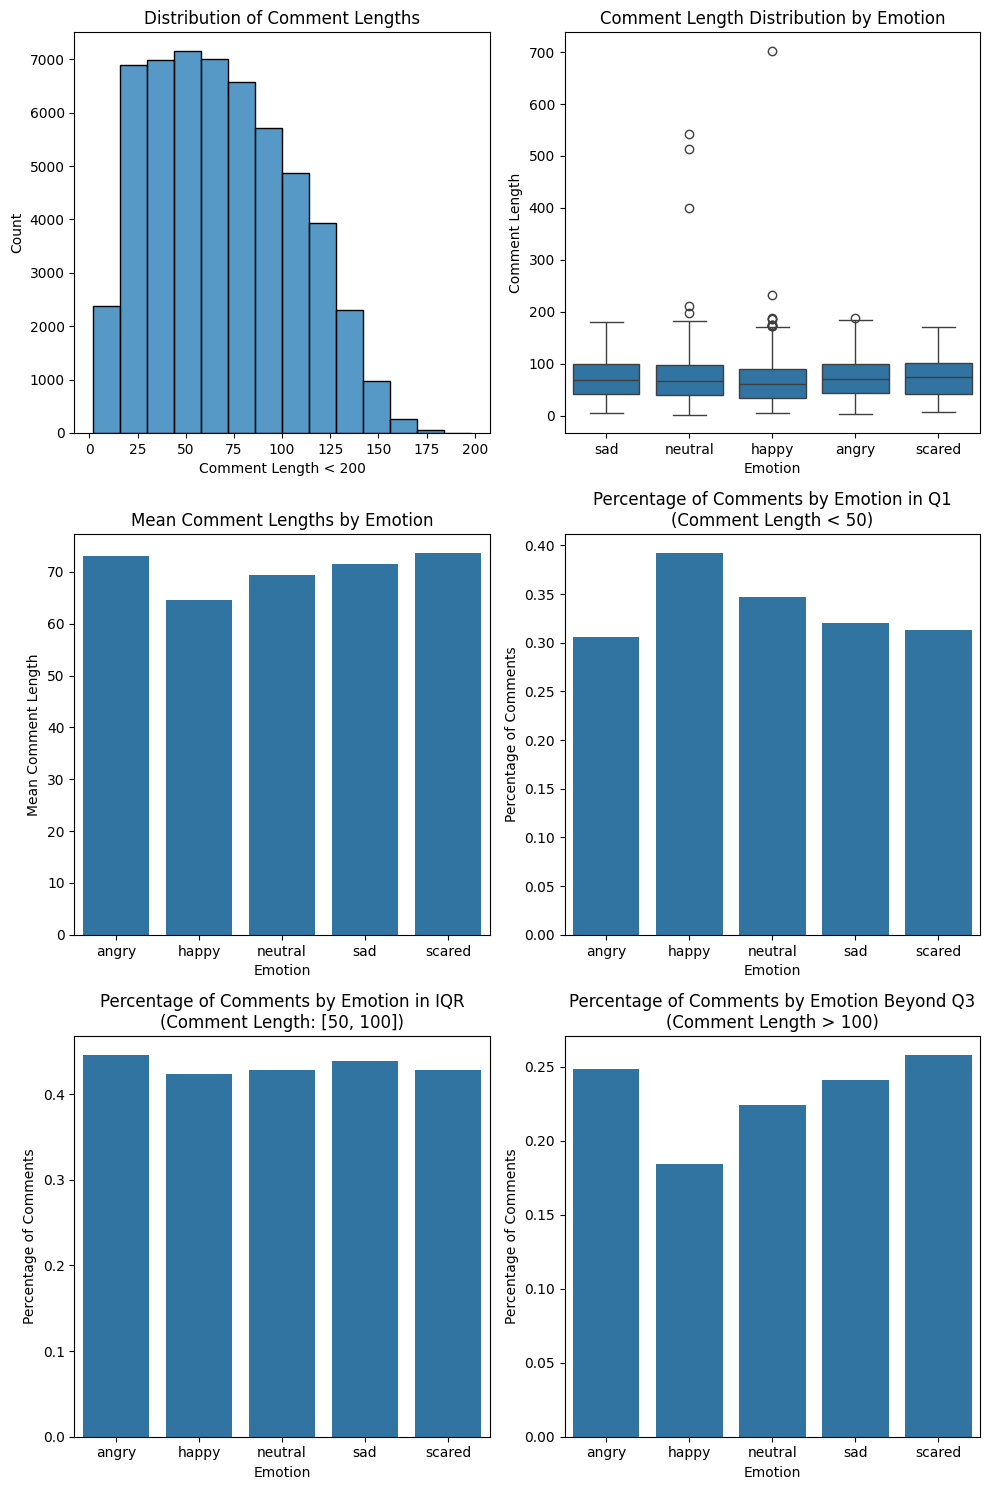

In [7]:
display(ds.groupby('emotion')['comment_length'].describe())

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Histogram to visualize distribution of values
sns.histplot(ds.loc[ds['comment_length'] < 200, 'comment_length'], bins=14, ax=axes[0][0])
axes[0][0].set_title('Distribution of Comment Lengths')
axes[0][0].set_xlabel('Comment Length < 200')
axes[0][0].set_ylabel('Count')

# Box plot to visualize distribution by emotion
sns.boxplot(x='emotion', y='comment_length', data=ds, ax=axes[0][1])
axes[0][1].set_title("Comment Length Distribution by Emotion")
axes[0][1].set_xlabel('Emotion')
axes[0][1].set_ylabel('Comment Length')

# Bar plot to visualize correlation with emotion
percents = ds.groupby('emotion')['comment_length'].mean()
sns.barplot(x=percents.index, y=percents, ax=axes[1][0])
axes[1][0].set_title('Mean Comment Lengths by Emotion')
axes[1][0].set_xlabel('Emotion')
axes[1][0].set_ylabel('Mean Comment Length')

# Bar plot to visualize correlation with emotion 
q1_percents = ds.groupby('emotion')['comment_length'].agg(lambda group: group.lt(50).mean())
sns.barplot(x=q1_percents.index, y=q1_percents, ax=axes[1][1])
axes[1][1].set_title('Percentage of Comments by Emotion in Q1\n(Comment Length < 50)')
axes[1][1].set_xlabel('Emotion')
axes[1][1].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion 
iqr_percents = ds.groupby('emotion')['comment_length'].agg(lambda group: ((group >= 50) & (group <= 100)).mean())
sns.barplot(x=iqr_percents.index, y=iqr_percents, ax=axes[2][0])
axes[2][0].set_title('Percentage of Comments by Emotion in IQR\n(Comment Length: [50, 100])')
axes[2][0].set_xlabel('Emotion')
axes[2][0].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion 
q4_percents = ds.groupby('emotion')['comment_length'].agg(lambda group: group.gt(100).mean())
sns.barplot(x=q4_percents.index, y=q4_percents, ax=axes[2][1])
axes[2][1].set_title('Percentage of Comments by Emotion Beyond Q3\n(Comment Length > 100)')
axes[2][1].set_xlabel('Emotion')
axes[2][1].set_ylabel('Percentage of Comments')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Analysis

- Distribution of comment lengths has a positive skew
- Rough approximations: quartile 1 (Q1) between 0 and 50, interquartile (IQR) between 50 and 100, quartile 3 (Q3) to 4 (Q4) between 100 and 200, and a negligible number of outliers past 200
- Happy comments show a slight decrease in mean comment length
- Comments in Q1:
    - Consist of about 0.40 or 40% of happy comments, higher than other emotions
    - Consist of about 0.35 or 35% of neutral comments, slightly higher than in angry, sad, and scared comments
- Comments in IQR:
    - No visible correlation between comment length and emotion
- Comments beyond Q3:
    - Consist of about 0.18 or 18% of happy comments, lower than other emotions
    - Consist of about 0.22 or 22% of neutral comments, slightly lower than in angry, sad, and scared comments

### Discussion

- Comments less than 50 characters are more likely to be happy or neutral, maybe because happy people have less to say and short comments are harder to read emotion from
- Comments within 50-100 characters show no correlation with emotion, maybe because most comments are in this range, mixing too many patterns to extract signal from

### Conclusion

- No correlation between comment length and emotions for comments within 50-100 characters
- Happy and neutral comments are more likely in comments less than 50 characters and less likely in comments more than 100 characters
- Create a binary feature:
    - Value: 1 if the comment length is less than 50, otherwise 0
    - The hope is that when the
        - value is 0, the model will ignore the feature
        - value is 1, the model will predict with positive bias toward "happy" and "neutral"
- Create a binary feature:
    - Value: 1 if the comment length is more than 100, otherwise 0
    - The hope is that when the
        - value is 0, the model will ignore the feature
        - value is 1, the model will predict with negative bias toward "happy" and "neutral"  

In [8]:
ds['comment_short'] = ds['text'].str.len().lt(50).astype('int8')
ds['comment_long'] = ds['text'].str.len().gt(100).astype('int8')

display(ds[['comment_length', 'comment_short', 'comment_long']])

,comment_length,comment_short,comment_long
0,15,1,0
2,46,1,0
3,18,1,0
4,52,0,0
5,135,0,1
...,...,...,...
71088,61,0,0
71094,14,1,0
71095,22,1,0
71138,28,1,0


# EDA on Exclamation Mark Count

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,8949.0,0.140798,0.551605,0.0,0.0,0.0,0.0,12.0
happy,15722.0,0.339651,0.787451,0.0,0.0,0.0,0.0,13.0
neutral,26226.0,0.153474,0.577997,0.0,0.0,0.0,0.0,13.0
sad,3301.0,0.116328,0.528958,0.0,0.0,0.0,0.0,12.0
scared,935.0,0.117647,0.452283,0.0,0.0,0.0,0.0,4.0


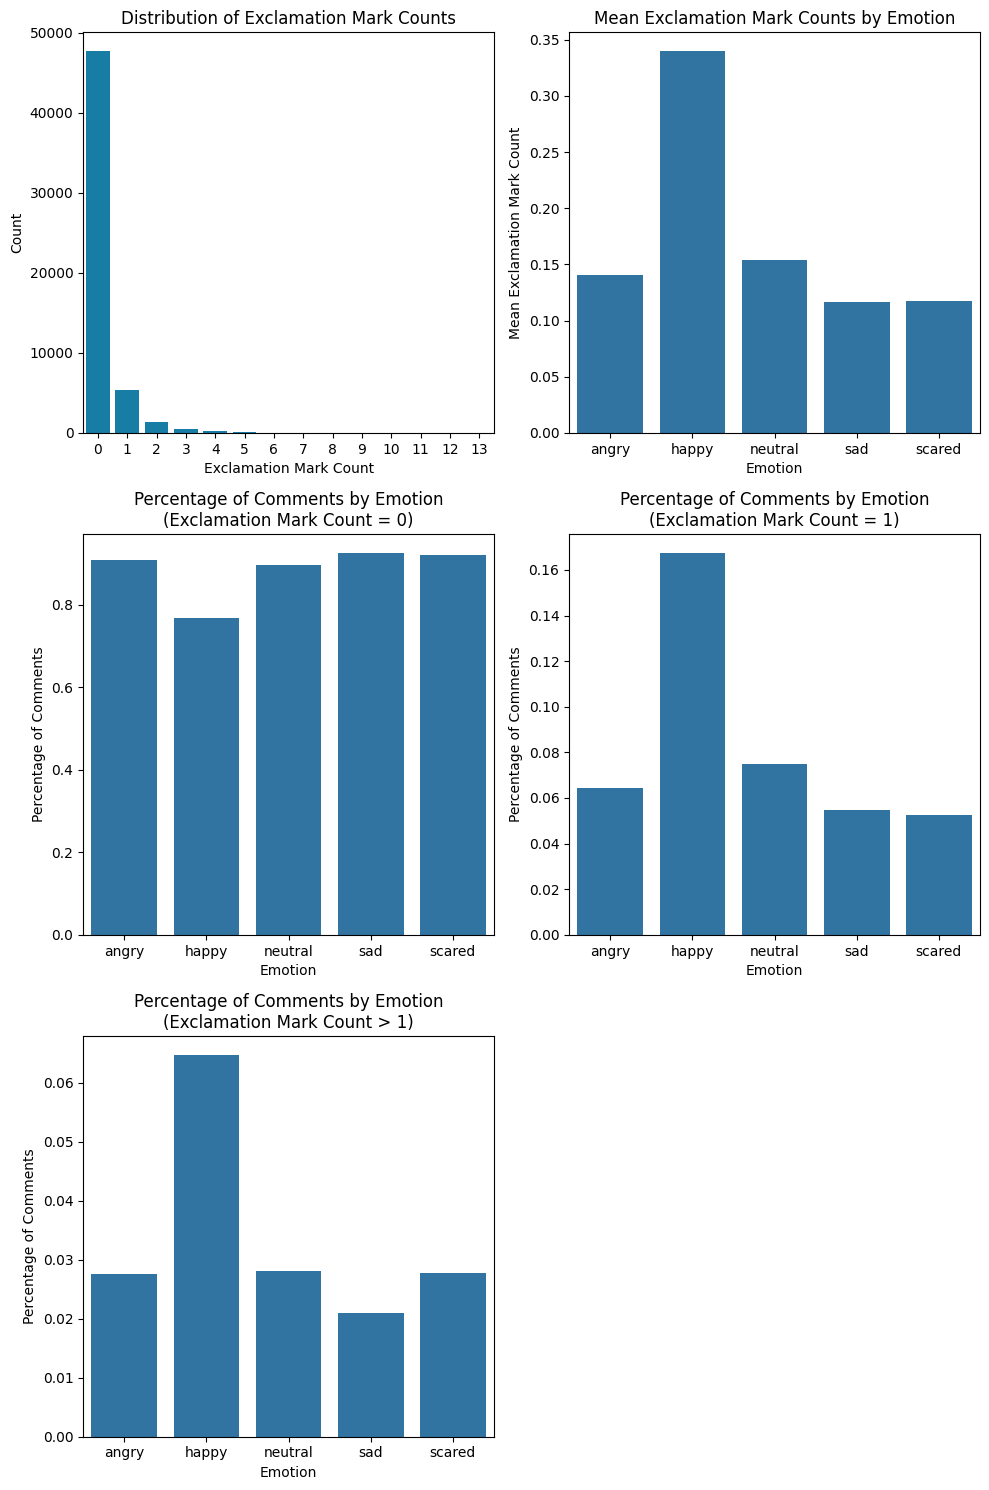

In [9]:
display(ds.groupby('emotion')['exclamation_mark_count'].describe())

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Bar plot to visualize distribution of values
distribution = ds['exclamation_mark_count'].value_counts()
sns.barplot(x=distribution.index, y=distribution, color='#0087BD', ax=axes[0][0])
axes[0][0].set_title('Distribution of Exclamation Mark Counts')
axes[0][0].set_xlabel('Exclamation Mark Count')
axes[0][0].set_ylabel('Count')

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['exclamation_mark_count'].mean()
sns.barplot(x=means.index, y=means, ax=axes[0][1])
axes[0][1].set_title('Mean Exclamation Mark Counts by Emotion')
axes[0][1].set_xlabel('Emotion')
axes[0][1].set_ylabel('Mean Exclamation Mark Count')

# Bar plot to visualize correlation with emotion
percents = ds.groupby('emotion')['exclamation_mark_count'].agg(lambda group: group.eq(0).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[1][0])
axes[1][0].set_title('Percentage of Comments by Emotion\n(Exclamation Mark Count = 0)')
axes[1][0].set_xlabel('Emotion')
axes[1][0].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion
percents = ds.groupby('emotion')['exclamation_mark_count'].agg(lambda group: group.eq(1).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[1][1])
axes[1][1].set_title('Percentage of Comments by Emotion\n(Exclamation Mark Count = 1)')
axes[1][1].set_xlabel('Emotion')
axes[1][1].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion
percents = ds.groupby('emotion')['exclamation_mark_count'].agg(lambda group: group.gt(1).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[2][0])
axes[2][0].set_title('Percentage of Comments by Emotion\n(Exclamation Mark Count > 1)')
axes[2][0].set_xlabel('Emotion')
axes[2][0].set_ylabel('Percentage of Comments')

axes[2][1].set_visible(False)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Analysis

- Distribution of exclamation mark counts are heavily positive skewed, with almost 50,000 comments that have 0 exclamation marks and about 5,000 comments with 1
- Happy comments contain almost 0.35 mean exclamation marks, more than twice that of other emotions
- Comments with 0 exclamation marks:
    - Consists of about 0.8 or 80% of happy comments, lower than other emotions
- Comments with 1 exclamation mark:
    - Consists of about 0.16 or 16% of happy comments, higher than other emotions
- Comments with multiple exclamation marks:
    - Consists of about 0.06 or 6% of happy comments, higher than other emotions
    - Neutral and sad comments decrease in percentage relative to other emotions

### Discussion

- Happy comments have the most exclamation marks on average and are less likely to have 0, maybe because the exclamation mark best expresses happiness than other emotions
- As the number of multiple exclamation marks rise, the likelihood for neutral and sad comments decreases, maybe because the use of exclamation marks conflict most with feelings of neutrality or sadness

### Conclusion

- Comments with 0 exclamation marks are less likely to be happy
- Comments with 1 or more exclamation marks are very likely to be happy
- Comments with increasing exclamation marks are increasingly unlikely to be neutral or sad
- Current feature "exclamation_mark_count": the hope is that when the
    - value is 0, the model will predict with negative bias toward "happy"
    - value is 1, the model with predict with positive bias toward "happy"
    - value increases, the model will predict with increasing negative bias toward "neutral" and "sad"

# EDA on Question Mark Count

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,8949.0,0.093642,0.355292,0.0,0.0,0.0,0.0,6.0
happy,15722.0,0.050184,0.251376,0.0,0.0,0.0,0.0,6.0
neutral,26226.0,0.189850,0.482199,0.0,0.0,0.0,0.0,10.0
sad,3301.0,0.057558,0.298005,0.0,0.0,0.0,0.0,5.0
scared,935.0,0.079144,0.324158,0.0,0.0,0.0,0.0,3.0


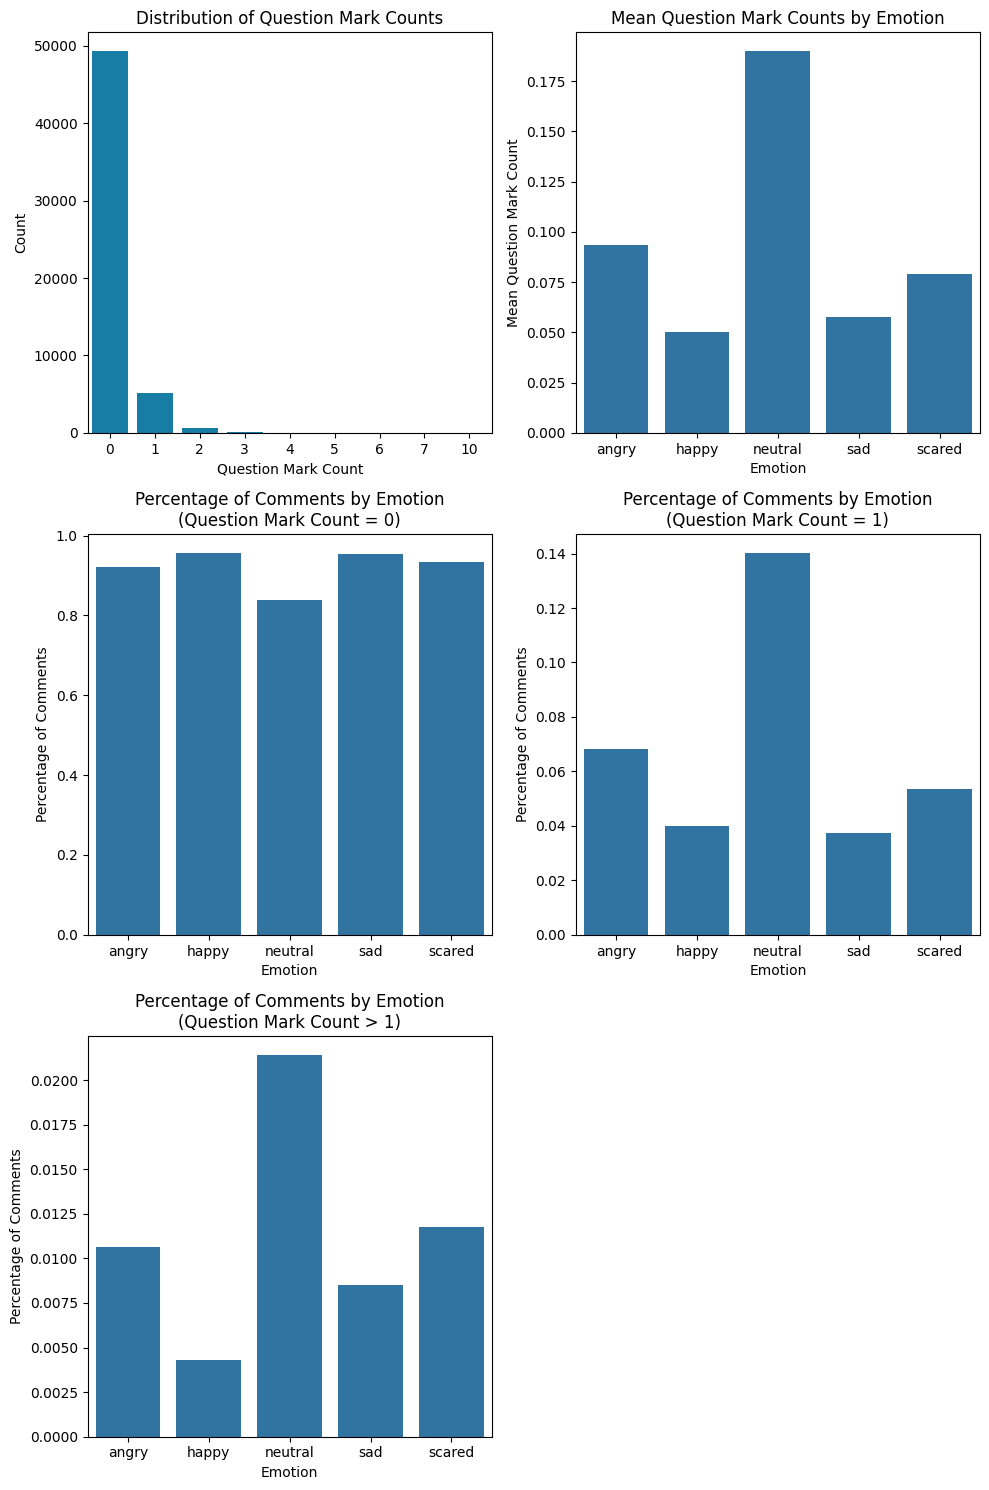

In [10]:
display(ds.groupby('emotion')['question_mark_count'].describe())

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Bar plot to visualize distribution of values
distribution = ds['question_mark_count'].value_counts()
sns.barplot(x=distribution.index, y=distribution, ax=axes[0][0], color='#0087BD')
axes[0][0].set_title('Distribution of Question Mark Counts')
axes[0][0].set_xlabel('Question Mark Count')
axes[0][0].set_ylabel('Count')

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['question_mark_count'].mean()
sns.barplot(x=means.index, y=means, ax=axes[0][1])
axes[0][1].set_title('Mean Question Mark Counts by Emotion')
axes[0][1].set_xlabel('Emotion')
axes[0][1].set_ylabel('Mean Question Mark Count')

# Bar plot to visualize correlation with emotion
percents = ds.groupby('emotion')['question_mark_count'].agg(lambda group: group.eq(0).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[1][0])
axes[1][0].set_title('Percentage of Comments by Emotion\n(Question Mark Count = 0)')
axes[1][0].set_xlabel('Emotion')
axes[1][0].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion
percents = ds.groupby('emotion')['question_mark_count'].agg(lambda group: group.eq(1).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[1][1])
axes[1][1].set_title('Percentage of Comments by Emotion\n(Question Mark Count = 1)')
axes[1][1].set_xlabel('Emotion')
axes[1][1].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion
percents = ds.groupby('emotion')['question_mark_count'].agg(lambda group: group.gt(1).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[2][0])
axes[2][0].set_title('Percentage of Comments by Emotion\n(Question Mark Count > 1)')
axes[2][0].set_xlabel('Emotion')
axes[2][0].set_ylabel('Percentage of Comments')

axes[2][1].set_visible(False)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Analysis

- Distribution of question mark counts is heavily positive skewed, with almost 50,000 comments with 0 question marks and about 5,000 with only 1 
- Neutral comments have almost 0.190 question marks on average, other comments have on average less than 0.100
- Comments with 0 question marks:
    - Consist of about 0.8 or 80% of neutral comments, less than other emotions
- Comments with 1 question mark:
    - Consist of about 0.14 or 14% of neutral comments, higher than all other emotions
- Comments with multiple question marks:
    - Consist of about 0.0200 or 2% of neutral comments, higher than all other emotions
    - Sad and scared comments have risen in percentage relative to angry and happy percentages
    - Happy comments have lowered in percentage relative to the rest

### Discussion

- Neutral comments have the most question marks maybe because being inquisitive puts priority on rationality than emotion
- As the number of question marks increases, the likelihood the comment is
    - sad or scared rises, maybe because more question marks means the comment is more desperate than inquisitive
    - happy lowers, maybe because more questioning means less satisfaction and happiness

### Conclusion

- Comments with 0 question marks have less chance of being neutral than other emotions
- Comments with 1 question mark have a much higher chance of being neutral than other emotions
- Comments with multiple question marks have a much higher chance of being neutral, with increased chance of being sad and scared relative to angry and happy chances
- Current feature "question_mark_count":
    - The hope is that when the
        - value is 0, the model will predict with a negative bias toward "neutral"
        - value is 1, the model will predict with a positive bias toward "neutral"
        - value increases, the model will predict with a positive bias toward "neutral", an increasing positive bias toward "sad" and "scared", and an increasing negative bias toward "happy"

# EDA on Quotation Count

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,8949.0,0.061906,0.377583,0.0,0.0,0.0,0.0,8.0
happy,15722.0,0.043824,0.308356,0.0,0.0,0.0,0.0,4.0
neutral,26226.0,0.063296,0.381704,0.0,0.0,0.0,0.0,6.0
sad,3301.0,0.054529,0.339422,0.0,0.0,0.0,0.0,4.0
scared,935.0,0.036364,0.263325,0.0,0.0,0.0,0.0,2.0


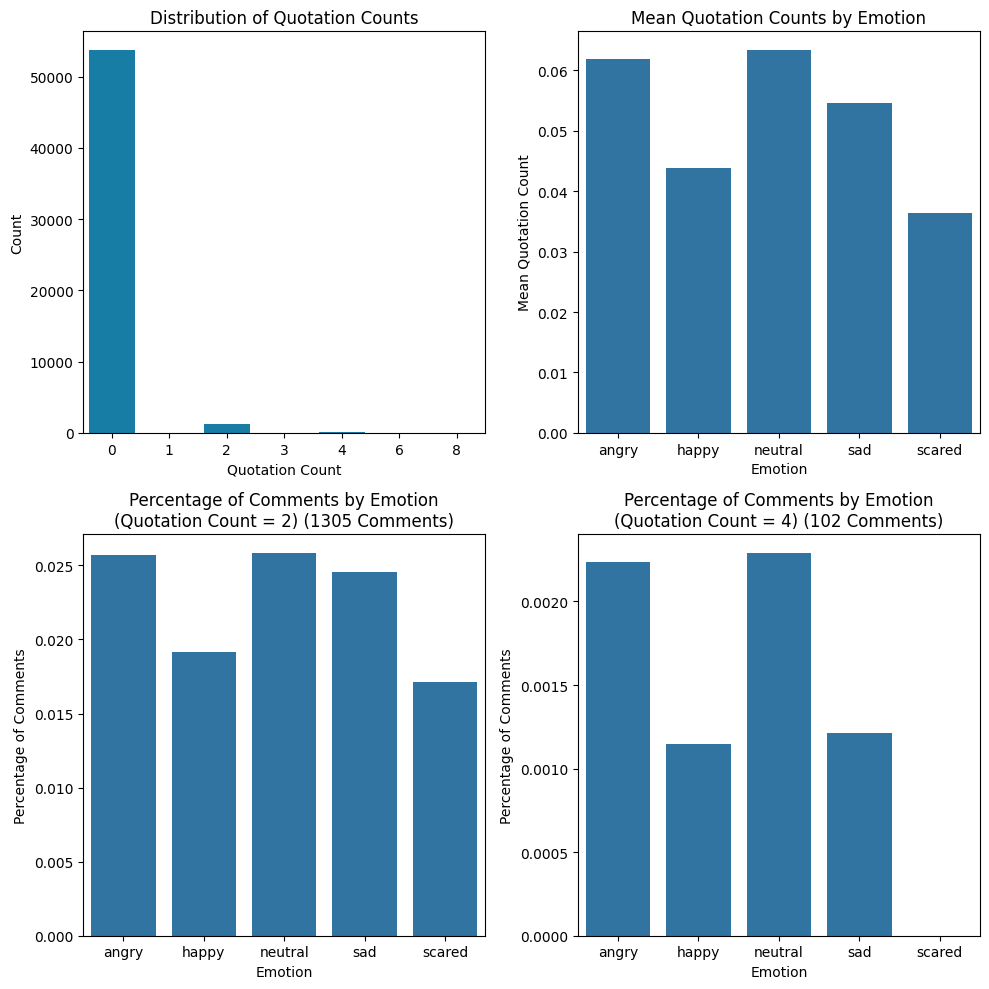

In [11]:
display(ds.groupby('emotion')['quotation_count'].describe())

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Bar plot to visualize distribution of values
distribution = ds['quotation_count'].value_counts()
sns.barplot(x=distribution.index, y=distribution, color='#0087BD', ax=axes[0][0])
axes[0][0].set_title('Distribution of Quotation Counts')
axes[0][0].set_xlabel('Quotation Count')
axes[0][0].set_ylabel('Count')

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['quotation_count'].mean()
sns.barplot(x=means.index, y=means, ax=axes[0][1])
axes[0][1].set_title('Mean Quotation Counts by Emotion')
axes[0][1].set_xlabel('Emotion')
axes[0][1].set_ylabel('Mean Quotation Count')

# Bar plot to visualize correlation with emotion
quote_percent = ds.groupby('emotion')['quotation_count'].agg(lambda group: group.eq(2).mean())
sns.barplot(x=quote_percent.index, y=quote_percent, ax=axes[1][0])
axes[1][0].set_title('Percentage of Comments by Emotion\n(Quotation Count = 2) ({} Comments)'.format(ds['quotation_count'].eq(2).sum()))
axes[1][0].set_xlabel('Emotion')
axes[1][0].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion
quote_percent = ds.groupby('emotion')['quotation_count'].agg(lambda group: group.eq(4).mean())
sns.barplot(x=quote_percent.index, y=quote_percent, ax=axes[1][1])
axes[1][1].set_title('Percentage of Comments by Emotion\n(Quotation Count = 4) ({} Comments)'.format(ds['quotation_count'].eq(4).sum()))
axes[1][1].set_xlabel('Emotion')
axes[1][1].set_ylabel('Percentage of Comments')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Analysis

- Distribution is mostly 0 with some in multiples of 2, with over 50,000 comments with 0 double quotes
- Comments on average have less double quotes if they are happy, sad, or scared
- Comments containing 0 double quotes:
    - Consist of about 0.06 or 6% of both angry and neutral comments, more than other emotions
- Comments containing 2 double quotes:
    - Consist of about 0.020 or 2% of happy comments and about 0.017 or 1.7% of scared comments, less than other emotions
- Comments containing 4 double quotes:
    - Consist of about 0.0012 or 0.12% of happy and sad comments and 0% of scared comments, much less than other emotions

### Discussion

- Distribution of double quote comes in multiples of 2 likely because double quotes are being used for quotes, each of which need to be wrapped by two double quotes
- Angry comments may contain more quotes due to the need to quote those they complain about
- Neutral comments may contain more quotes due to explanations, where quotes are useful as persuasive evidence
- Happy, sad, and scared comments may contain less quotes because they're focused less on quoting others and more focused toward expressing themselves

### Conclusion

- Happy, sad, and scared comments are less likely to have quotes than angry and neutral comments, and this increases as quotation marks increase 
- Happy and sad comments are further less likely to have two quotes
- Current feature "quotation_count": the hope is that as the value increases, the model will predict with increasing positive bias toward "angry" and "neutral"

# EDA on Period Count

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,8949.0,1.190301,1.245866,0.0,0.0,1.0,2.0,17.0
happy,15722.0,1.048594,1.202506,0.0,0.0,1.0,2.0,18.0
neutral,26226.0,1.039770,1.233494,0.0,0.0,1.0,2.0,20.0
sad,3301.0,1.183884,1.200175,0.0,0.0,1.0,2.0,11.0
scared,935.0,1.208556,1.297474,0.0,0.0,1.0,2.0,12.0


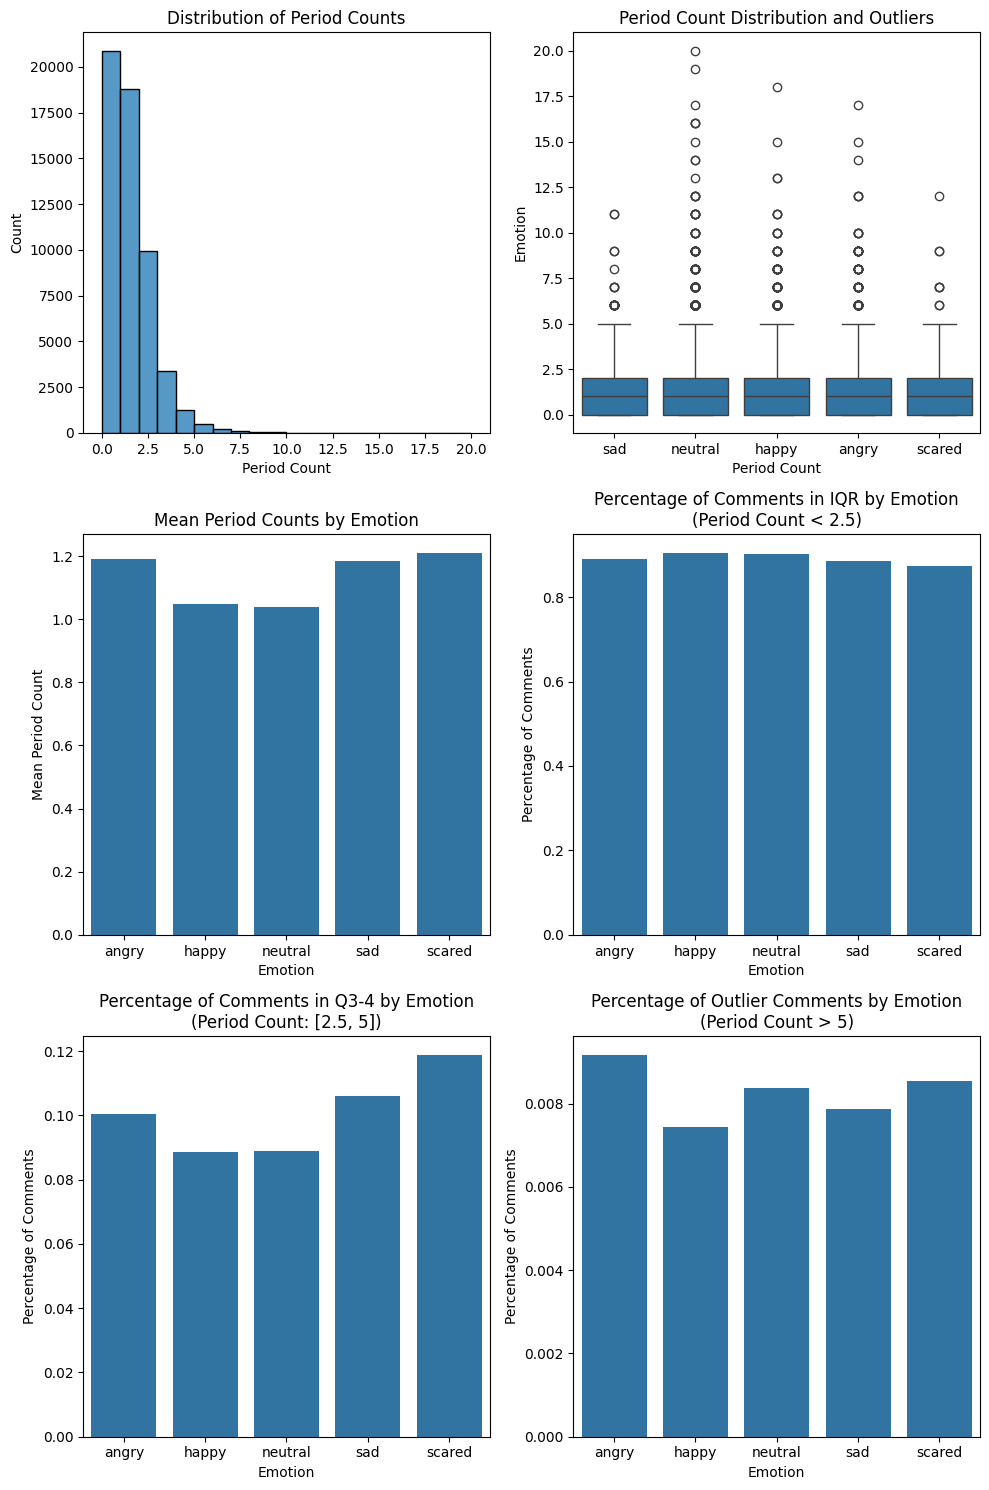

,text,period_count,emotion
40,Na. Rediting my post. Sorry for the ignorance.,3,sad
147,I've never seen him play so hard on defense. This feels different this time is all I'm saying...,4,sad
316,Idgaf anymore. I lost all hope in moids. I'll keep looksmaxxing for myself.,3,sad
413,I've been watching too much my 600lb life...I instantly hear dr. [NAME],4,sad
449,oh my [NAME]. it was hurting my brain. i only saw the disappearing boot and thought i was missing something.,3,sad
...,...,...,...
12735,I interview applicants and respect people that ask about work life balance and harassment policy... are applicants afraid of asking these questions?,3,scared
15825,"Tried it. Failed it. Got mental consequences, my memory wont recover after half a year. You will regret it.",4,sad
18195,"To show themself in public like that they never did grow up. A 11 year old in a 25 year old body. Sad, really.",3,sad
28155,Umm Hmmm. Too bad [NAME] can't be reached via Ouija Board. People really need his help.,3,sad


In [12]:
display(ds.groupby('emotion')['period_count'].describe())

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Histogram to visualize distribution of values
sns.histplot(ds['period_count'], bins=20, ax=axes[0][0])
axes[0][0].set_title('Distribution of Period Counts')
axes[0][0].set_xlabel('Period Count')
axes[0][0].set_ylabel('Count')

# Box plot to visualize distribution by emotion
sns.boxplot(x='emotion', y='period_count', data=ds, ax=axes[0][1])
axes[0][1].set_title("Period Count Distribution and Outliers")
axes[0][1].set_xlabel('Period Count')
axes[0][1].set_ylabel('Emotion')

# Bar plot to visualize correlation with emotion
percents = ds.groupby('emotion')['period_count'].mean()
sns.barplot(x=percents.index, y=percents, ax=axes[1][0])
axes[1][0].set_title('Mean Period Counts by Emotion')
axes[1][0].set_xlabel('Emotion')
axes[1][0].set_ylabel('Mean Period Count')

# Bar plot to visualize correlation with emotion 
percents = ds.groupby('emotion')['period_count'].agg(lambda group: group.lt(2.5).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[1][1])
axes[1][1].set_title('Percentage of Comments in IQR by Emotion\n(Period Count < 2.5)')
axes[1][1].set_xlabel('Emotion')
axes[1][1].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion 
percents = ds.groupby('emotion')['period_count'].agg(lambda group: (group.ge(2.5) & group.le(5)).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[2][0])
axes[2][0].set_title('Percentage of Comments in Q3-4 by Emotion\n(Period Count: [2.5, 5])')
axes[2][0].set_xlabel('Emotion')
axes[2][0].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion 
percents = ds.groupby('emotion')['period_count'].agg(lambda group: group.gt(5).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[2][1])
axes[2][1].set_title('Percentage of Outlier Comments by Emotion\n(Period Count > 5)')
axes[2][1].set_xlabel('Emotion')
axes[2][1].set_ylabel('Percentage of Comments')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Show points of most target variation
display(ds.loc[ds['period_count'].ge(2.5) & ds['period_count'].le(5) & (ds['emotion'].eq('scared') | ds['emotion'].eq('sad')), ['text', 'period_count', 'emotion']])

### Analysis

- Distribution is positive skewed, with almost half of the dataset's comments containing no periods
- Approximations: quartile 0 to 3 occurs in the range [0, 2.5), quartile 3 to 4 occurs in range \[2.5, 5.0\], and outliers occur beyond a period count of 5
- On average, happy and neutral comments have less periods
- For comments within the IQR:
    - 0.9 or 90% of each emotion's comments contain this range of periods; likely no correlation between period count IQR and emotion
- For comments within quartiles 3 to 4:
    - About 0.09 or 9% of both happy and neutral comments contain this range's period count, lower than other emotions
    - About 0.10 or 10% of both angry and sad comments contain this range's period count, lower thaan scared comments
- Comments more than 5 periods show some slight variation in emotions

### Discussion

- Happy and neutral comments have the least periods on average, maybe because they're the most light-hearted emotions out of the 5, resulting in more informal language with less use of periods
- Comments with less than 3 periods seem to have no correlation with emotion, maybe because there are too many factors behind period count that aren't emotionally driven (ex. abbreviations, sentence endings, personality, etc)
- Comments containing between 3 to 5 periods inclusively seem to have a higher chance of being scared or sad, maybe because this number of periods is enough for an double_dot ("..."), which can be used as a tool for suspense or sign of weakness

### Conclusion

- Comments with less than 3 periods show no correlation between period count as emotion
- Comments with 3 to 5 periods have an increased chance of being scared, sad, or angry
- Create a feature:
    - Values: the number of periods in the comment more than 2
    - The hope is that when the
        - value is 0, the model will ignore the feature
        - value is 1, the model will predict with positive bias toward "scared" and negative bias toward "happy" and "neutral"
        - value increases, the model will predict with positive bias toward "angry" and negative bias toward "happy

In [13]:
ds['masked_period_count'] = ds['period_count'].sub(2).clip(0)

display(ds.groupby('period_count').agg({'masked_period_count': 'first'}).loc[1:7])

,masked_period_count
period_count,
1,0
2,0
3,1
4,2
5,3
6,4
7,5


# EDA on Double Dot Count

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,8949.0,0.083250,0.374801,0.0,0.0,0.0,0.0,8.0
happy,15722.0,0.071174,0.336238,0.0,0.0,0.0,0.0,8.0
neutral,26226.0,0.089339,0.383833,0.0,0.0,0.0,0.0,9.0
sad,3301.0,0.086943,0.346431,0.0,0.0,0.0,0.0,4.0
scared,935.0,0.103743,0.399326,0.0,0.0,0.0,0.0,5.0


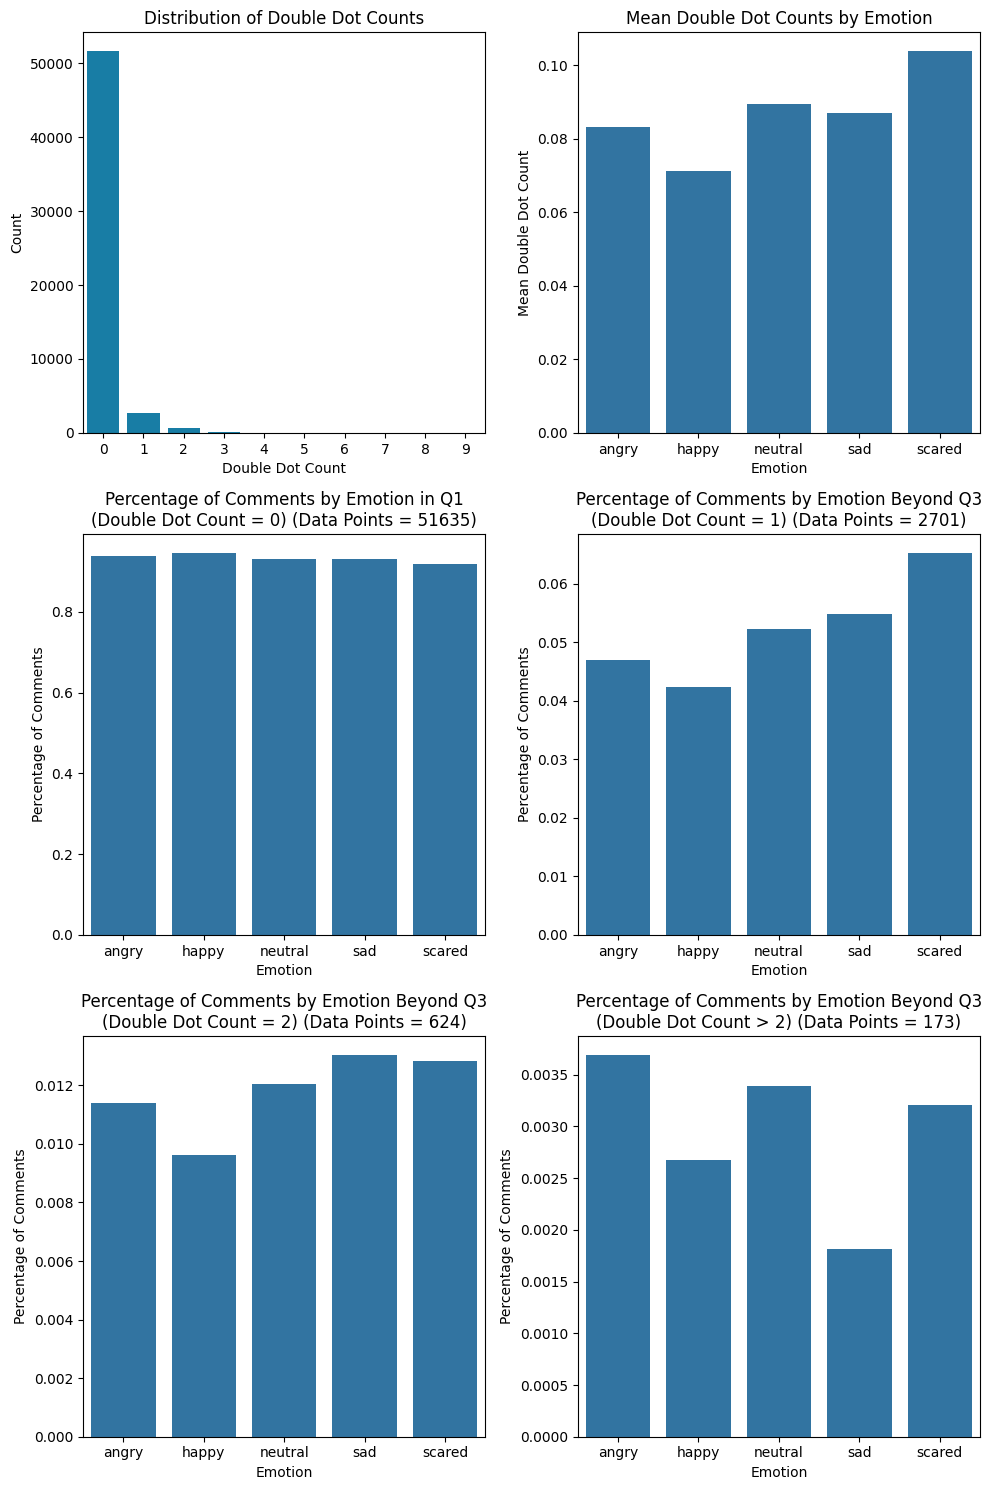

,text,double_dot_count,emotion
139,Umm... I do it everyday since I was 13 and I’m fine... could be just me...,3,neutral
734,... [NAME] derangement syndrome sufferer spotted. What drivel you crazy lunatics say... The lies and falsehoods along with the out of place fearmongering is getting really annoying...,3,angry
1245,Contractions is equivalent....body can only deal with...us women with labor.....I don’t like the way this person speaks.,5,happy
1584,"""We must fight!....to run away..""",3,neutral
1696,And let us not forget the lord's privilege with a new bride. Ahhhh......the good old days.,3,happy
...,...,...,...
60730,Yes.... base on the things I’ve seen on his phone but he said he never rly did it....,4,neutral
67902,Oh fuck off. Soooo...... when is [NAME] and the gang going to un mask [NAME] as President [NAME]?,3,angry
20191,that is an ar-15................,8,neutral
28104,What...the...actual...**** 😂 are you high?,3,neutral


In [14]:
display(ds.groupby('emotion')['double_dot_count'].describe())

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Histogram to visualize distribution of values
distribution = ds['double_dot_count'].value_counts()
sns.barplot(x=distribution.index, y=distribution, color='#0087BD', ax=axes[0][0])
axes[0][0].set_title('Distribution of Double Dot Counts')
axes[0][0].set_xlabel('Double Dot Count')
axes[0][0].set_ylabel('Count')

# Bar plot to visualize correlation with emotion
percents = ds.groupby('emotion')['double_dot_count'].mean()
sns.barplot(x=percents.index, y=percents, ax=axes[0][1])
axes[0][1].set_title('Mean Double Dot Counts by Emotion')
axes[0][1].set_xlabel('Emotion')
axes[0][1].set_ylabel('Mean Double Dot Count')

# Bar plot to visualize correlation with emotion 
percents = ds.groupby('emotion')['double_dot_count'].agg(lambda group: group.eq(0).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[1][0])
axes[1][0].set_title('Percentage of Comments by Emotion in Q1\n(Double Dot Count = 0) (Data Points = {})'.format(ds['double_dot_count'].eq(0).sum()))
axes[1][0].set_xlabel('Emotion')
axes[1][0].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion 
percents = ds.groupby('emotion')['double_dot_count'].agg(lambda group: group.eq(1).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[1][1])
axes[1][1].set_title('Percentage of Comments by Emotion Beyond Q3\n(Double Dot Count = 1) (Data Points = {})'.format(ds['double_dot_count'].eq(1).sum()))
axes[1][1].set_xlabel('Emotion')
axes[1][1].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion 
percents = ds.groupby('emotion')['double_dot_count'].agg(lambda group: group.eq(2).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[2][0])
axes[2][0].set_title('Percentage of Comments by Emotion Beyond Q3\n(Double Dot Count = 2) (Data Points = {})'.format(ds['double_dot_count'].eq(2).sum()))
axes[2][0].set_xlabel('Emotion')
axes[2][0].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion 
percents = ds.groupby('emotion')['double_dot_count'].agg(lambda group: group.gt(2).mean())
sns.barplot(x=percents.index, y=percents, ax=axes[2][1])
axes[2][1].set_title('Percentage of Comments by Emotion Beyond Q3\n(Double Dot Count > 2) (Data Points = {})'.format(ds['double_dot_count'].gt(2).sum()))
axes[2][1].set_xlabel('Emotion')
axes[2][1].set_ylabel('Percentage of Comments')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Show outliers or points of most target variation
display(ds.loc[ds['double_dot_count'].gt(2), ['text', 'double_dot_count', 'emotion']])

### Analysis

- Distribution has positive skew, with almost all comments containing no double dots and only roughly 5,000 containing any
- Happy comments average the lowest of about 0.04 double dots per comment while scared comments average the highest of about 0.10
- Percentage of comments with 0 double dots are similar in percentage across all emotions, suggesting no correlation between emotion and having no double dots
- Comments with 1 double dot:
    - About 0.04 or 4% of happy comments, lowest out of emotions
    - About 0.06 or 6% of scared emotions, highest out of emotions
- Comments with 2 double dots:
    - About 0.010 or 1% of happy comments, lowest out of emotions
    - About 0.013 or 1.3% of sad comments, highest out of emotions
- Comments with more than 2 double dots:
    - About 0.0017 or 0.17% of sad comments, lowest out of emotions
    - About 0.0025 or 0.25% of angry comments, highest out of emotions

### Discussion

- Scared comments average the highest number of double dots, maybe because of their use in ellipses for suspense
- Happy comments average the least number of double dots, maybe because chained dots usually are accompanied with a lower level of energy, which happiness isn't often paired with
- Comments with more than two double dots are most likely angry, maybe because the use of double dots takes on the role of conveying drama or speechlessness
- Comments with more than two double dots are least likely sad, maybe because too many double dots is excessively dramatic and is less interesting as a tool of self-expression

### Conclusion

- As the number of a comment's double dots increases, the likelihood of it being happy or sad decreases, and the likelihood of it being scared or angry increases
- Current feature "double_dot_count": the hope is that when the
    - value is 0, the model will ignore the feature
    - value is 1, the model will predict with positive bias toward "scared" and negative bias toward "happy"
    - value is 2, the model will predict with negative bias toward "happy"
    - value > 2, the model will predict with negative bias toward "happy" and "sad"


# EDA on Uppercase Count

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,8949.0,2.733378,5.339542,0.0,1.0,2.0,3.0,110.0
happy,15722.0,2.468643,3.517465,0.0,1.0,2.0,3.0,106.0
neutral,26226.0,2.508465,4.565777,0.0,1.0,2.0,3.0,274.0
sad,3301.0,2.349894,3.059455,0.0,1.0,2.0,3.0,55.0
scared,935.0,2.429947,4.649510,0.0,1.0,2.0,3.0,92.0


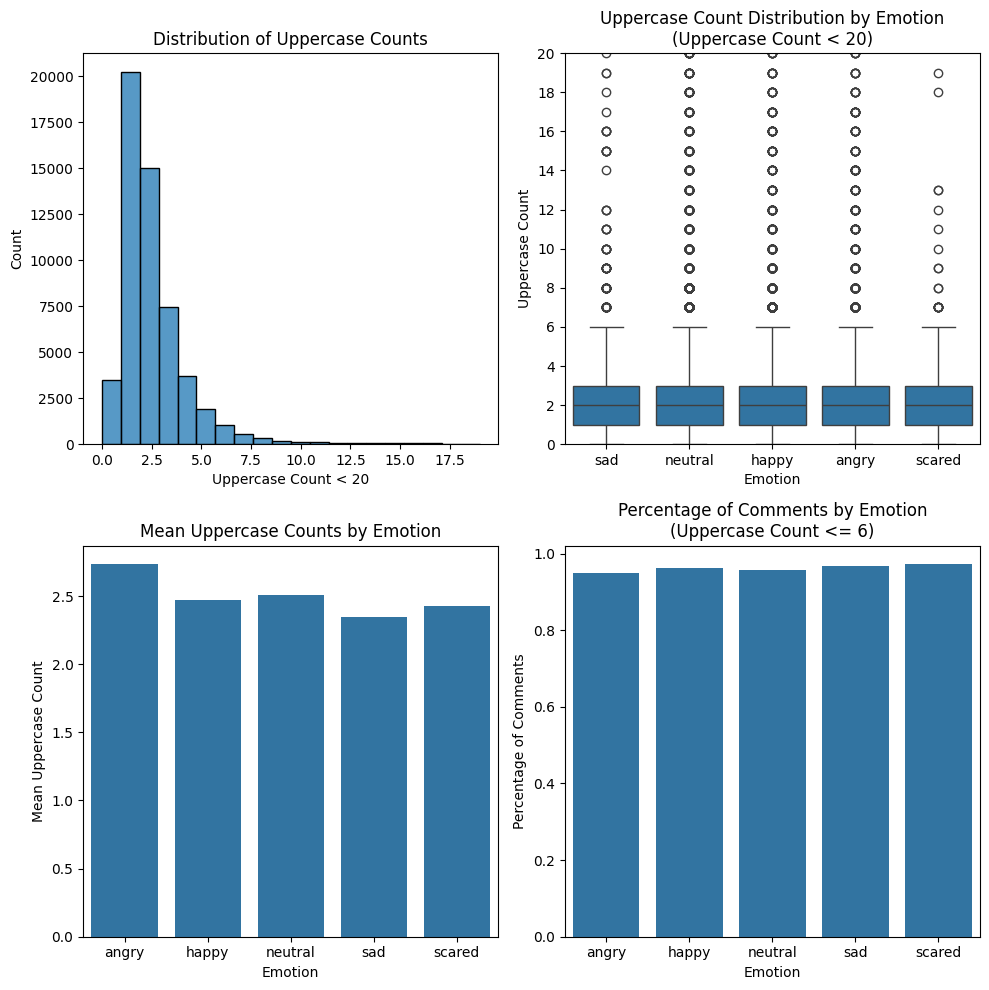

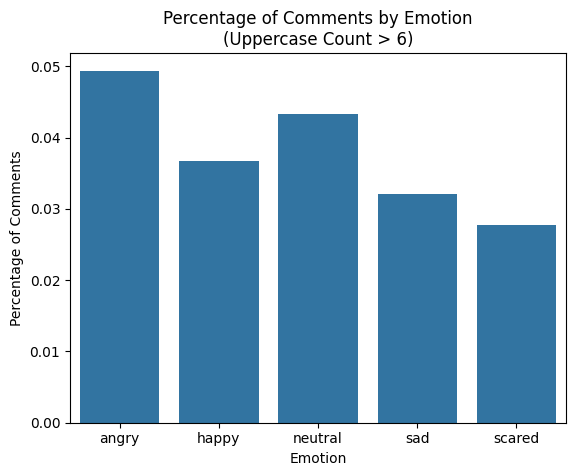

In [15]:
display(ds.groupby('emotion')['uppercase_count'].describe())

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Bar plot to visualize distribution of values
close_up = ds.loc[ds['uppercase_count'] < 20, 'uppercase_count']
sns.histplot(close_up, bins=20, edgecolor='black', ax=axes[0][0])
axes[0][0].set_title('Distribution of Uppercase Counts')
axes[0][0].set_xlabel('Uppercase Count < 20')
axes[0][0].set_ylabel('Count')

# Box plot to visualize distribution by emotion
sns.boxplot(x='emotion', y='uppercase_count', data=ds, ax=axes[0][1])
axes[0][1].set_title('Uppercase Count Distribution by Emotion\n(Uppercase Count < 20)')
axes[0][1].set_xlabel('Emotion')
axes[0][1].set_ylabel('Uppercase Count')
axes[0][1].set_yticks(range(0, 150, 2))
axes[0][1].set_ylim(0, 20)

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['uppercase_count'].mean()
sns.barplot(x=means.index, y=means, ax=axes[1][0])
axes[1][0].set_title('Mean Uppercase Counts by Emotion')
axes[1][0].set_xlabel('Emotion')
axes[1][0].set_ylabel('Mean Uppercase Count')

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['uppercase_count'].agg(lambda group: group.le(6).mean())
sns.barplot(x=means.index, y=means, ax=axes[1][1])
axes[1][1].set_title('Percentage of Comments by Emotion\n(Uppercase Count <= 6)')
axes[1][1].set_xlabel('Emotion')
axes[1][1].set_ylabel('Percentage of Comments')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['uppercase_count'].agg(lambda group: group.gt(6).mean())
sns.barplot(x=means.index, y=means)
plt.title('Percentage of Comments by Emotion\n(Uppercase Count > 6)')
plt.xlabel('Emotion')
plt.ylabel('Percentage of Comments')
plt.show()

### Analysis

- Distribution is positive skewed
- Outliers begin after about the value 6
- Comments have a mean uppercase count of about 2.50, similar across emotions
- Comments with less than or equal to 6 uppercase letters have a mean uppercase count of about 2, similar across emotions
- For comments with more than 6 uppercase letters, angry and scared comments on average contain significantly more uppercase letters

### Discussion

- The majority of comments (where uppercase count <= 6) likely have no correlation between uppercase count and emotion, maybe because there are too many noisy factors for uppercase count shared across emotions (ex. capital letters and comment length, proper nouns, nonspecific emotional high, etc)
- Outlier comments (where upper case > 6) have angry comments with significantly more uppercase letters than other comments on average, maybe because some noisy factors have been filtered out by then (ex. it's less likely for a comment to have 6+ sentences and capital letters), and thus more extreme factors like anger or fear persist in contributing to uppercase count

### Conclusion

- When comments contain 6 or less uppercase letters, there's no correlation between uppercase count and emotion
- When comments contain more than 6 uppercase letters, angry and scared comments contain more uppercase letters on average
- Create a feature:
    - Values: the number of uppercase letters over 6 in the comment
    - The hope is that when the
        - value is 0, the model will ignore the feature
        - value increases, the model will predict with increasing positive bias toward "angry" and "scared"

In [16]:
ds['masked_uppercase_count'] = ds['uppercase_count'].sub(6).clip(0)

display(ds.groupby('uppercase_count').agg({'masked_uppercase_count': 'first'}).loc[4:9])

,masked_uppercase_count
uppercase_count,
4,0
5,0
6,0
7,1
8,2
9,3


# EDA on Double Uppercase Count

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,8949.0,0.709353,4.101106,0.0,0.0,0.0,0.0,85.0
happy,15722.0,0.392444,2.534071,0.0,0.0,0.0,0.0,83.0
neutral,26226.0,0.545527,3.595942,0.0,0.0,0.0,0.0,269.0
sad,3301.0,0.356862,2.183382,0.0,0.0,0.0,0.0,42.0
scared,935.0,0.422460,3.430579,0.0,0.0,0.0,0.0,72.0


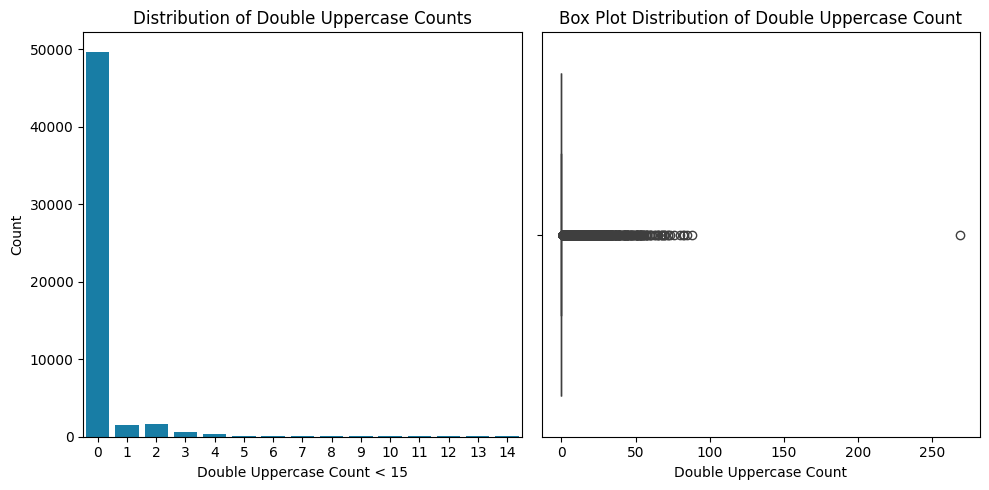

,text,double_uppercase_count,emotion
6591,No the whippet sound is WUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUBWUB And then you need another balloon. Spot on with the gunshot though. Just like intense temporary tinnitus.,269,neutral


,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,8949.0,0.709353,4.101106,0.0,0.0,0.0,0.0,85.0
happy,15722.0,0.392444,2.534071,0.0,0.0,0.0,0.0,83.0
neutral,26225.0,0.535291,3.191085,0.0,0.0,0.0,0.0,88.0
sad,3301.0,0.356862,2.183382,0.0,0.0,0.0,0.0,42.0
scared,935.0,0.422460,3.430579,0.0,0.0,0.0,0.0,72.0


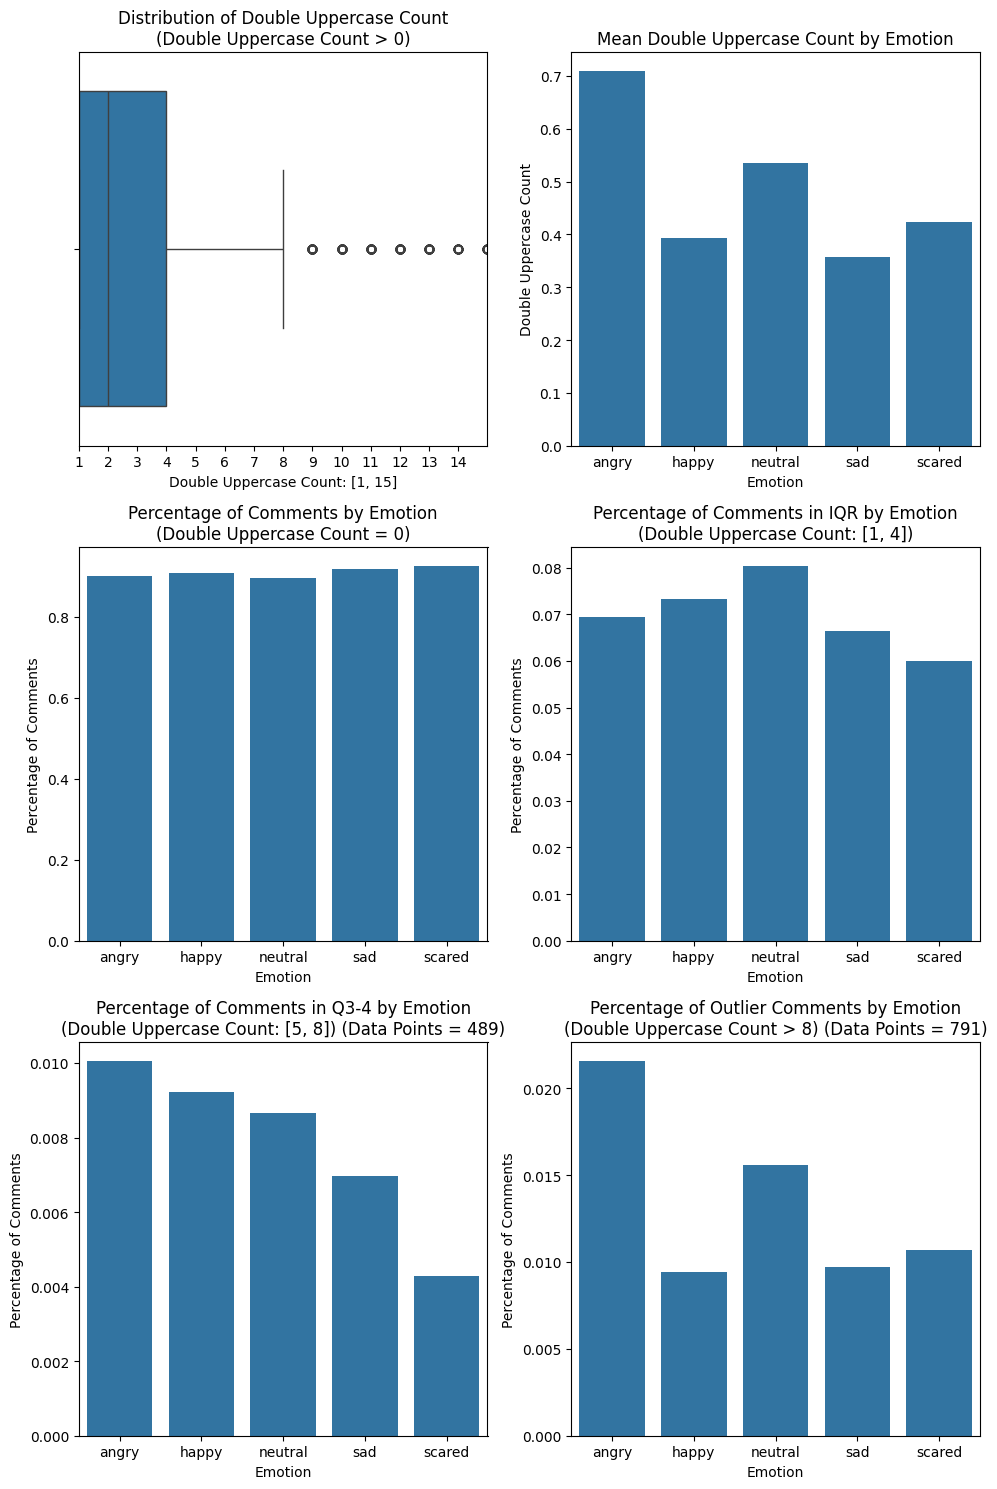

,text,double_uppercase_count,emotion
12,BUT IT'S HER TURN! /s,8,neutral
71,"The service made it 20 years ago (1999, yeah ikr 1999 was 20 YEARS AGO?)",6,neutral
74,Who exactly are their ‘volunteers’? The IRA?,2,neutral
75,Am I the only INTP here who cared about deadlines. It's how I got so good at crunch time and working last minute.,3,neutral
92,I didn't like the family ending but I liked the Atlantis ending especially as we know we are going to see more of it in DLC2.,2,neutral
...,...,...,...
70903,[NAME] AND PORZINGOD UNDER THE TUTILAGE OF DADDY DIRK PINCH ME I MUST BE DREAMING,47,neutral
70922,HUGE difference e b/t “seniors housing” and “nursing home.” HUGE DIFFERENCE.,15,neutral
70936,I'm sorry if this is Real but this sounds like something from r/thathappened But if it is Real then kudos and sąd that the EK didnt buy you a ps4,1,neutral
70940,Perhaps you are right and the stereotype that ASD people are math savants may not be as true as I thought 🤔,2,neutral


In [17]:
display(ds.groupby('emotion')['double_uppercase_count'].describe())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Bar plot to visualize distribution of values
distribution = ds.loc[ds['double_uppercase_count'].lt(15), 'double_uppercase_count'].value_counts()
sns.barplot(x=distribution.index, y=distribution, color='#0087BD', ax=axes[0])
axes[0].set_title('Distribution of Double Uppercase Counts')
axes[0].set_xlabel('Double Uppercase Count < 15')
axes[0].set_ylabel('Count')

# Box plot to visualize distribution
sns.boxplot(ds, x='double_uppercase_count', ax=axes[1])
axes[1].set_title('Box Plot Distribution of Double Uppercase Count')
axes[1].set_xlabel('Double Uppercase Count')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

display(ds.loc[ds['double_uppercase_count'].gt(250), ['text', 'double_uppercase_count', 'emotion']])

ds = ds.loc[ds['double_uppercase_count'].lt(250)]

fig, axes = plt.subplots(3, 2, figsize=(10, 15))
display(ds.groupby('emotion')['double_uppercase_count'].describe())

# Box plot to visualize distribution
distribution = ds.loc[ds['double_uppercase_count'].gt(0)]
sns.boxplot(distribution, x='double_uppercase_count', ax=axes[0][0])
axes[0][0].set_title('Distribution of Double Uppercase Count\n(Double Uppercase Count > 0)')
axes[0][0].set_xlabel('Double Uppercase Count: [1, 15]')
axes[0][0].set_xticks(range(1, 15))
axes[0][0].set_xlim(1, 15)

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['double_uppercase_count'].mean()
sns.barplot(x=means.index, y=means, ax=axes[0][1])
axes[0][1].set_title('Mean Double Uppercase Count by Emotion')
axes[0][1].set_xlabel('Emotion')
axes[0][1].set_ylabel('Double Uppercase Count')

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['double_uppercase_count'].agg(lambda group: group.eq(0).mean())
sns.barplot(x=means.index, y=means, ax=axes[1][0])
axes[1][0].set_title('Percentage of Comments by Emotion\n(Double Uppercase Count = 0)')
axes[1][0].set_xlabel('Emotion')
axes[1][0].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['double_uppercase_count'].agg(lambda group: group.between(1, 4).mean())
sns.barplot(x=means.index, y=means, ax=axes[1][1])
axes[1][1].set_title('Percentage of Comments in IQR by Emotion\n(Double Uppercase Count: [1, 4])')
axes[1][1].set_xlabel('Emotion')
axes[1][1].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['double_uppercase_count'].agg(lambda group: group.between(5, 8).mean())
sns.barplot(x=means.index, y=means, ax=axes[2][0])
axes[2][0].set_title('Percentage of Comments in Q3-4 by Emotion\n(Double Uppercase Count: [5, 8]) (Data Points = {})'.format(ds['double_uppercase_count'].between(5, 8).sum()))
axes[2][0].set_xlabel('Emotion')
axes[2][0].set_ylabel('Percentage of Comments')

# Bar plot to visualize correlation with emotion
means = ds.groupby('emotion')['double_uppercase_count'].agg(lambda group: group.gt(8).mean())
sns.barplot(x=means.index, y=means, ax=axes[2][1])
axes[2][1].set_title('Percentage of Outlier Comments by Emotion\n(Double Uppercase Count > 8) (Data Points = {})'.format(ds['double_uppercase_count'].gt(8).sum()))
axes[2][1].set_xlabel('Emotion')
axes[2][1].set_ylabel('Percentage of Comments')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Investigate double uppercase letters in neutral comments
display(ds.loc[ds['emotion'].eq('neutral') & ds['double_uppercase_count'].gt(0), ['text', 'double_uppercase_count', 'emotion']])


### Analysis

- Distribution is positive skewed with thousands of comments that have at least 1 occurrence of double uppercase letters
- There is one major extreme outlier with over 250 double uppercase letters
    - This outlier contained over 250 uppercase letters likely for a comical effect, which is why I consider it not correctly neutral and have thus removed it
- Distribution of double uppercase count for values over 0:
    - Quartile 0 to quartile 3 range between values 1 to 4
    - Quartile 3 to 4 range between values 5 to 8
    - Outliers occur after 8 double uppercase letters
- On average:
    - Angry comments contain about 0.7 double uppercase letters, highest percentage
    - Sad comments contain about 0.35 double uppercase letters, lowest percentage
- Comments with 0 double uppercase letters comprise equal percentage of all emotions; 0 double uppercase letters likely doesn't correlate with emotion
- Comments with between 1 to 4 double uppercase letters inclusively:
    - Consist of about 0.08 or 8% of neutral comments, highest percentage
    - Consist of about 0.06 or 6% of scared comments, lowest percentage
- Comments with between 5 to 8 double uppercase letters inclusively:
    - Consist of about 0.010 or 1% of angry comments, highest percentage
    - Consist of about 0.004 or 0.4% of scared comments, lowest percentage
- Comments with over 8 double uppercase letters:
    - Consist of about 0.020 or 2% of angry comments, highest percentage
    - Consist of about 0.010 or 1% of happy comments, lowest percentage

### Discussion

- Angry comments have the highest average number of double uppercase letters, maybe because angry yelling is represented by continuous uppercase letters
- Happy, sad, and scared comments have the lowest mean number of double uppercase letters, maybe because it's rare for such comments to convey yelling
- It's most likely for a comment with 1 to 4 double uppercase letters to be neutral, maybe because those cases often involve an acronym instead of any extreme emotional expression

### Conclusion

- As the number of double uppercase letters increase:
    - Angry comments decrease then increase in likelihood
    - Happy comments decrease in likelihood
    - Neutral comments increase then decrease in likelihood
    - Sad comments decrease in likelihood
    - Scared comments decrease in likelihood
- Current feature "double_uppercase_count": the hope is that as the value increases, the model predicts with respect to the pattern above

# EDA on Pairwise Relationships

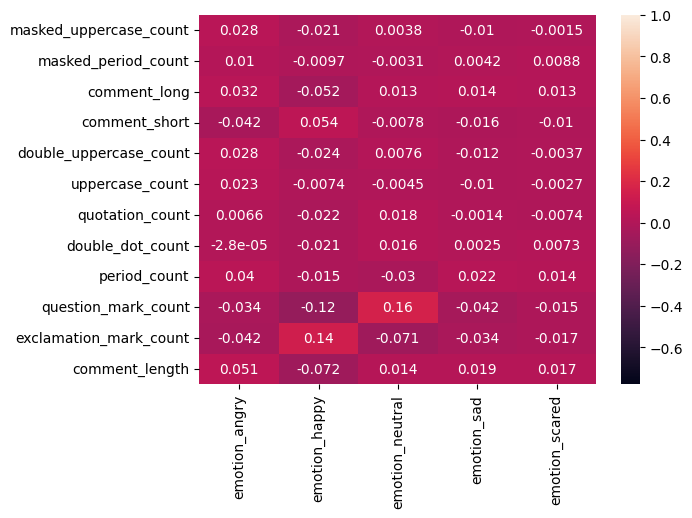

In [18]:
heatmap_df = pd.get_dummies(ds.drop('text', axis=1)).corr()
sns.heatmap(heatmap_df, annot=True, annot_kws=dict(clip_on=True))
plt.xlim(12, 17)
plt.ylim(0, 12)
plt.show()

### Analysis

- comment_length
    - comment_long and comment_short individually have worse correlation scores than comment_length, but added together they correlate more than just comment_length
    - comment_long and comment_short have inverse correlations with their corresponding emotions, because they address different stages of comment_length when emotions correlate in a different direction
- period_count
    - masked_period_count has lower correlation scores in most emotions, because periods and emotions correlation very non-linearly; by capturing more of this pattern, masked_period_count has lower correlation
- uppercase_count
    - masked_uppercase_count has higher correlation scores in most emotions, because it ignores the range of uppercase letters where there's little to no correlation with emotion

# EDA on N-Grams

,N-gram,MI for Happy
9,thanks,0.019063
2,love,0.018179
15,thank,0.016541
20,thank you,0.015408
11,lol,0.012762
27,great,0.009059
65,thanks for,0.008244
4,good,0.006832
138,awesome,0.006089
142,amazing,0.005469


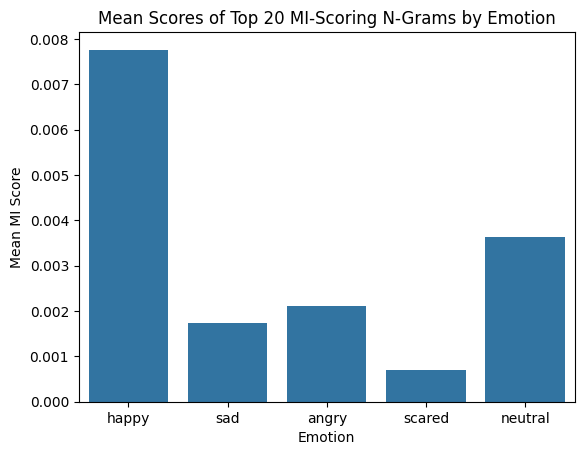

Top Important N-Grams (Union Across Emotions):
{'poor', 'nice', 'the fuck', 'appreciate', 'great', 'lol', 'feel', 'miss', 'haha', 'disgusting', 'hope', 'creepy', 'you for', 'die', 'imagine', 'thank', 'awful', 'hate', 'thanks', 'stupid', 'unfortunately', 'fuck', 'glad', 'didn', 'about it', 'thank you', 'love it', 'amazing', 'sorry for', 'loss', 'worry', 'afraid', 'watching', 'missed', 'happy', 'stop', 'so sorry', 'don', 'funny', 'bad', 'crying', 'worst', 'lost', 'terrible', 'sorry', 'the worst', 'hurt', 'scared', 'horrible', 'love this', 'fucking', 'cool', 'shit', 'cringe', 'good', 'love', 'awesome', 'weird', 'sad', 'thanks for', 'worried'}


In [19]:
# Top 20 n-grams per emotion based on MI
top_mi_ngrams = set()
top_mi_ngrams_dfs = []

def get_top_mi_ngrams():
    # N-gram vectorizer for unigrams and bigrams
    vectorizer = CountVectorizer(ngram_range=(1, 2))
    
    # N-grams
    X = vectorizer.fit_transform(ds['text'])
    ngram_names = vectorizer.get_feature_names_out()
    ngram_df = pd.DataFrame.sparse.from_spmatrix(
        X, 
        index=ds.index,
        columns=ngram_names
    )
    
    # N-gram frequencies
    ngram_counts = ngram_df.sum()
    top_1000_ngram_counts = ngram_counts \
        .drop(set(stopwords), errors='ignore') \
        .sort_values(ascending=False) \
        .head(1000)
    
    for emotion in emotions.keys():
        # Calculate MI scores for top 1000 n-grams respective to current emotion
        top_1000_ngram_names = top_1000_ngram_counts.index
        emotion_binary = ds['emotion'] == emotion
        mi = mutual_info_classif(ngram_df[top_1000_ngram_names], 
                                 emotion_binary, 
                                 discrete_features=True)
        
        # Create a DataFrame of n-grams and their MI scores
        mi_df = pd.DataFrame({'N-gram': top_1000_ngram_names, 
                              f'MI for {emotion.capitalize()}': mi})
        
        # Sort by MI score and select the 20 most important n-grams for each sentiment
        top_20_mi_ngrams = mi_df.sort_values(by=f'MI for {emotion.capitalize()}', 
                                             ascending=False).head(20)
        
        top_mi_ngrams.update(top_20_mi_ngrams['N-gram'].to_list())
        top_mi_ngrams_dfs.append(top_20_mi_ngrams)

get_top_mi_ngrams()

# Display top MI-scoring n-grams per emotion
display_multiple(*top_mi_ngrams_dfs)

# Display mean MI scores per emotion's top 20 n-grams
means = [df[df.columns[1]].mean() for df in top_mi_ngrams_dfs]
sns.barplot(x=['happy', 'sad', 'angry', 'scared', 'neutral'], y=means)
plt.title('Mean Scores of Top 20 MI-Scoring N-Grams by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Mean MI Score')
plt.show()

# Display all top 20 MI-scoring n-grams
print('Top Important N-Grams (Union Across Emotions):', top_mi_ngrams, sep='\n')

### Analysis

- Going by average scores for each emotion's top MI-scoring n-grams, the most to least explainable emotions:
    1. happy
    2. neutral
    3. angry
    4. sad
    5. scared
 
### Conclusion

- Using the n-grams, a model will predict some emotions with higher precision than others
- Include each top MI-scoring n-gram as a binary feature
    - Value: 1 if the n-gram is in the comment, 0 otherwise
    - The hope is that when the
        -  value is 0, the model will ignore the feautre
        -  value is 1, the model will predict with positive bias toward whichever emotion the n-gram is associated with

In [20]:
important_ngrams = {
    'nice', 'cringe', 'awful', 'watching', 'great', 'sad', 'worst', 'stop', 
    'thanks', 'you for', 'horrible', 'scared', 'about it', 'worry', 'haha', 
    'unfortunately', 'sorry for', 'terrible', 'lol', 'hope', 'shit', 
    'the fuck', 'glad', 'thank', 'love', 'miss', 'crying', 'missed', 'sorry', 
    'amazing', 'so sorry', 'appreciate', 'imagine', 'lost', 'funny', 'cool', 
    'weird', 'stupid', 'love this', 'hate', 'fuck', 'happy', 'fucking', 
    'good', 'afraid', 'bad', 'thank you', 'awesome', 'the worst', 'die', 
    'hurt', 'love it', 'thanks for', 'poor', 'feel', 'disgusting'
}

# Create Preprocessors

In [21]:
# Regex patterns for handling specific Reddit content
URL_PATTERN = r'http[s]?://\S+|www\.\S+'
MENTION_PATTERN = r'@\w+'
HASHTAG_PATTERN = r'#\w+'

# Slang translations
slang_dict = {
    'lol': 'amused',
    'lmao': 'hilarious',
    'rofl': 'rolling_on_floor_laughing',
    'omg': 'surprised',
    'brb': 'temporarily_away',
    'wtf': 'confused',
    'fml': 'frustrated',
    'smh': 'disbelief',
    'omfg': 'extremely_surprised',
    'idk': 'unsure',
    'tbh': 'honestly',
    'sus': 'suspicious',
    'bruh': 'exasperated',
    'noob': 'inexperienced',
    'simp': 'overly_adoring',
    'tldr': 'summary',
    'fomo': 'fear_of_missing_out',
    'yta': 'you_are_the_asshole',
    'nta': 'not_the_asshole',
    'nvm': 'forget_it',
    'gg': 'good_game',
    'cya': 'goodbye',
    'lmfao': 'laughing_my_ass_off',
    'tifu': 'today_i_fucked_up',
    'wbu': 'what_about_you',
    'ty': 'thank_you',
    'yw': 'you_are_welcome',
    'iama': 'i_am_a',
    'eli5': 'explain_like_im_5',
    'ftw': 'for_the_win',
    'fyi': 'for_your_information',
    'np': 'no_problem',
    'wb': 'welcome_back',
    'lit': 'exciting',
    'fam': 'friend',
    'stan': 'extremely_support',
    'savage': 'bold_and_ruthless',
    'cap': 'lie_or_false',
    'no cap': 'honestly',
    'lmk': 'let_me_know',
    'sksksk': 'excited_or_sentimental_laughter',
    'stfu': 'shut_up',
    'lowkey': 'slightly',
    'highkey': 'very',
    'yeet': 'throw_or_discard',
    'af': 'as_fuck',
    'deadass': 'seriously',
    'ppl': 'people',
    'imo': 'in_my_opinion',
    'wdym': 'what_do_you_mean',
    'kys': 'kill_yourself',
    'kms': 'kill_myself'
}

# Symbol translations
symbol_dict = {
    ':)': 'happy',
    ':-)': 'happy',
    ':D': 'happy',
    ':-D': 'happy',
    ':P': 'happy',
    ':-P': 'happy',
    ':]': 'happy',
    ':-]': 'happy',
    ':3': 'happy',
    ':^)': 'happy',
    ':(': 'sad',
    ':-(': 'sad',
    'D:': 'sad',
    ':-C': 'sad',
    'T_T': 'sad',
    ":'(": 'sad',
    ':|': 'neutral',
    ':o': 'neutral',
    ':-o': 'neutral',
    'O:': 'neutral',
    'O:-': 'neutral',
    '^_^': 'happy',
    '>:(': 'angry',
    '>:-(': 'angry',
    ':X': 'angry',
    ':@': 'angry',
    ':-|': 'neutral',
    ':/': 'neutral',
    ':\\': 'neutral',
    ':-/': 'neutral',
    ';-)': 'playful',
    ';P': 'playful',
    ':*': 'love',
    '<3': 'love',
    '/s': 'satire',
    '/jk': 'just_kidding'
}

# Emoji translations
emoji_dict = {
    '😢': 'sad',
    '😊': 'happy',
    '❤️': 'love',
    '😂': 'laugh',
    '😡': 'angry',
    '😱': 'scared',
    '😔': 'sad',
    '😓': 'sad',
    '😞': 'sad',
    '😜': 'playful',
    '😎': 'cool',
    '😒': 'angry',
    '😃': 'happy',
    '🤔': 'neutral',
    '😌': 'happy',
    '🥺': 'sad',
    '😇': 'neutral',
    '😍': 'love',
    '🥰': 'love',
    '🙃': 'playful',
    '😔': 'sad',
    '😳': 'embarrassed',
    '😅': 'happy',
    '😵': 'scared',
    '😋': 'happy',
    '😤': 'angry',
    '💀': 'laugh',
    '🥳': 'happy',
    '🤗': 'happy',
    '🤩': 'happy',
}

# Stopwords to retain as they contribute sentiment information
stopword_exceptions = {
    'not', 'very', 'really', 'too', 'just', 'even', 'so', 
    'still', 'quite', 'always', 'never', 'sometimes', 
    'more', 'less', 'almost', 'kinda', 'sorta', 'meh', 
    'yet', 'really', 'always'
}

# Punctuation to retain as they contribute sentiment information
punctuation_exceptions = {'!', '?', '.'}

### PREPROCESSORS ###

class BasePreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self


class RedditTextCleaner(BasePreprocessor):
    '''An sklearn transformer that cleans reddit comments.'''
    def transform(self, X):
        '''Preprocess a pandas series of strings.'''
        X_copy = pd.DataFrame(X)
        X_copy['text'] = X['text'].apply(self._preprocess_reddit_comment)
        return X_copy

    def _preprocess_reddit_comment(self, text):
        '''Custom tokenizer for Reddit comments'''
        text = re.sub(URL_PATTERN, '<URL>', text)
        text = re.sub(MENTION_PATTERN, '<USER>', text)
        text = re.sub(HASHTAG_PATTERN, '<HASHTAG>', text)
        return text

class Tokenizer(BasePreprocessor):
    '''An sklearn transformer that tokenizes and processes text.''' 
    def __init__(self, exceptions=None):
        self.exceptions = (
            exceptions or
            stopword_exceptions.union(punctuation_exceptions)
        )

    def transform(self, X):
        '''Tokenize a pandas series of strings.'''
        print('Tokenizer...')
        nlp = spacy.load(
            'en_core_web_lg', 
            disable=['ner', 'parser', 'tok2vec']
        )
        token_docs = nlp.pipe(
            X['text'], batch_size=1000
        )
        X['tokens'] = [
            self._process_tokens(doc) for doc in token_docs
        ]
        return X

    def _process_tokens(self, tokens):
        '''Translate slang and symbols and filter punctuation and stopwords.'''
        processed_tokens = []
        for token in tokens:
            if token.lower_ in self.exceptions:
                processed_tokens.append(token.lower_)
            elif token.lower_ in slang_dict:
                processed_tokens.append(slang_dict.get(token.lower_))
            elif token.text in emoji_dict:
                processed_tokens.append(emoji_dict.get(token.text))
            elif not token.is_stop and token.is_alpha:
                processed_tokens.append(token.lemma_.lower())
        return processed_tokens


class FeatureEngineer(BasePreprocessor):
    '''An sklearn transformer that engineers features.'''
    def __init__(self, ngrams):
        self.ngrams = ngrams
        
    def transform(self, X):
        print('FeatureEngineer...')
        X['comment_short'] = X['text'].apply(len).lt(50).astype('int8')
        X['comment_long'] = X['text'].apply(len).gt(100).astype('int8')
        X['exclamation_mark_count'] = X['text'].str.count('!')
        X['question_mark_count'] = X['text'].str.count('\?')
        X['masked_period_count'] = X['text'].str.count('.').sub(2).clip(0)
        X['double_dot_count'] = X['text'].str.count('..')
        X['quotation_count'] = X['text'].str.count('""')
        X['masked_uppercase_count'] = X['text'].apply(
            lambda comment: sum(1 for c in self._remove_artifacts(comment) if c.isupper())
        ).sub(6).clip(0)
        X['double_uppercase_count'] = X['text'].apply(self._count_double_uppercase)
        X = self._add_ngrams(X)
        return X
        
    def _remove_artifacts(self, comment):
        artifacts = {'[T]', '[ALL]', '[NAME]', '[RELIGION]', 
                     '<URL>', '<USER>', '<HASHTAG>'}
        for artifact in artifacts:
            comment = comment.replace(artifact, '')
        return comment

    def _count_double_uppercase(self, comment):
        clean_comment = self._remove_artifacts(comment)
        return sum(1 for i in range(len(clean_comment)-1) 
                   if clean_comment[i].isupper() 
                   and clean_comment[i+1].isupper())
        
    def _add_ngrams(self, X):
        vectorizer = CountVectorizer(ngram_range=(1, 2), 
                                     vocabulary=self.ngrams)
        ngrams_csrm = vectorizer.fit_transform(X['text'])
        ngram_names = [
            'ngram_' + ngram 
            for ngram in vectorizer.get_feature_names_out()
        ]
        ngrams_df = pd.DataFrame.sparse.from_spmatrix(
            ngrams_csrm, 
            index=X.index,
            columns=ngram_names
        )
        return pd.concat([X, ngrams_df], axis=1)


class Scaler(BasePreprocessor):
    '''An sklearn transformer that scales input for machine learning.'''
    def __init__(self):
        self.scaler = StandardScaler()
        self.unscaled_features = [
            'masked_period_count', 'double_dot_count', 'quotation_count', 
            'exclamation_mark_count', 'question_mark_count', 
            'masked_uppercase_count', 'double_uppercase_count'
        ]
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.unscaled_features])
        return self
    
    def transform(self, X):
        print('Scaler...')
        scaled_data = self.scaler.transform(X[self.unscaled_features])
        X_scaled = pd.DataFrame(
            scaled_data, index=X.index, columns=self.unscaled_features
        )
        X_scaled = pd.concat([X.drop(self.unscaled_features, axis=1), X_scaled], axis=1)
        return X_scaled


class Cleaner(BasePreprocessor):
    '''An sklearn transformer that cleans up input for machine learning.'''
    def transform(self, X):
        '''Drop temporary features and compress features.'''
        print('Cleaner...')
        X_clean = X.drop(
            ['text', 'tokens', 'processed_tokens'], 
            axis=1, errors='ignore'
        )
        X_clean.columns = X_clean.columns.astype(str)
        X_csrm = csr_matrix(X_clean)
        return X_csrm

### EXAMPLE ###

example_pipeline = Pipeline([
    ('reddit_text_cleaner', RedditTextCleaner()),
    ('tokenizer', Tokenizer(stopword_exceptions.update({'/s', ':-)'}))),
    ('feature_engineer', FeatureEngineer(important_ngrams)),
    ('scaler', Scaler()),
    # ('feature_cleaner', Cleaner())
])

example_corpus = pd.DataFrame({'text': [
    'www.website.com @user #hashtag LOL NOT A ! ? . | /s """":-)'
]})

preprocessed_example = example_pipeline.fit_transform(example_corpus)
preprocessed_example

Tokenizer...
FeatureEngineer...
Scaler...


,text,tokens,comment_short,comment_long,ngram_about it,ngram_afraid,ngram_amazing,ngram_appreciate,ngram_awesome,ngram_awful,...,ngram_worry,ngram_worst,ngram_you for,masked_period_count,double_dot_count,quotation_count,exclamation_mark_count,question_mark_count,masked_uppercase_count,double_uppercase_count
0,"<URL> <USER> <HASHTAG> LOL NOT A ! ? . | /s """""""":-)","[url, user, hashtag, amused, not, !, ?, ., /s, :-)]",0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Experiment Setup

**Evaluation Metrics (Ordered by Priority)**
1. F1-score (measures balance of recall and precision)
2. Recall (measures how many correct predictions are made for each class)
3. Precision (measures how carefully predictions are made for each class)
4. Accuracy (measures how well the model fitted to the training set)

**Strategy**
1. Experiment with two pipeline strategies for traditional sentiment analysis: TF-IDF vectorization and embedding
    - TF-IDF vectorization
        - Transforms a corpus into a document term matrix, where each term's value represents the term's importance by how frequent it is in the same text in constrast with its frequency across the dataset
        - Each term's value tells the classifier how much importance the term carries in the comment
        - The hope is that sentimentally-similar comments place similar importance on similar terms and that the model can fit to this pattern
    - Embedding
        - Transforms each token into a vector whose every component carries the token's semantic meaning in some dimension
        - Embeddings in a comment can be averaged to tell the classifier the overall semantic meaning of the comment
        - The hope is that semantically-similar comments will be sentimentally-similar and that the model can fit to this pattern
2. Experiment with different classifiers on the best pipeline
3. Experiment with hyperparameter tuning on the best classifier

In [22]:
### CONFIGURATIONS ###

TRACKING_URI = os.environ['TRACKING_URI']

mlflow.set_tracking_uri(TRACKING_URI)

skip_experiments = True  # Toggle to skip/run experiments

### EXPERIMENT DATA STRUCTURE ###

class Experiment:
    def __init__(self, name, X, y):
        if not skip_experiments:
            mlflow.set_experiment(name)
        self.X = X
        self.y = y

    def _report_evaluation(self, name, y_pred, time):
        # Evaluate
        report = classification_report(
            self.y, y_pred, 
            target_names=['happy', 'sad', 'angry', 'scared', 'neutral'],
            output_dict=True, 
            zero_division=0
        )

        # Log individual metrics for each class
        for class_idx, class_name in enumerate(report.keys()):
            avgs = ['accuracy', 'macro avg', 'weighted avg']
            if class_name not in avgs:
                mlflow.log_metric(f'precision_class_{class_idx}', 
                                  report[class_name]['precision'])
                mlflow.log_metric(f'recall_class_{class_idx}', 
                                  report[class_name]['recall'])
                mlflow.log_metric(f'f1_class_{class_idx}', 
                                  report[class_name]['f1-score'])
        
        # Log overall accuracy and averages
        mlflow.log_metric('accuracy', report['accuracy'])
        mlflow.log_metric('precision_macro', report['macro avg']['precision'])
        mlflow.log_metric('recall_macro', report['macro avg']['recall'])
        mlflow.log_metric('f1_macro', report['macro avg']['f1-score'])

        # Print results
        print('Ran pipeline', name)
        print('Accuracy:', report['accuracy'])
        print('Precision macro:', report['macro avg']['precision'])
        print('Recall macro:', report['macro avg']['recall'])
        print('F1 macro:', report['macro avg']['f1-score'])
        print('Time {:.2f} seconds'.format(time))

    def run_evaluation(self, name, pipeline, fit_params={}):
        if skip_experiments:
            return

        classifier = pipeline.named_steps['classifier']

        full_params = [
            ('preprocessing_{}_{}'.format(i, name), step) 
            for (i, (name, step)) in enumerate(pipeline.named_steps.items())
        ] + [
            ('hyperparameter_{}'.format(name), hyperparameter) 
            for name, hyperparameter in classifier.get_params().items()
        ]
        
        with mlflow.start_run():
            for param_name, param in full_params:
                mlflow.log_param(param_name, param)
                
            start_time = time()
            
            print('Pipeline {}: cross-validation fitting and predicting...'.format(name), flush=True)
            y_pred = cross_val_predict(
                pipeline, self.X, self.y, fit_params=fit_params
            )
            
            end_time = time()
            
            self._report_evaluation(name, y_pred, end_time - start_time)
            
    def run_tuning(self, name, random_search):
        if skip_experiments:
            return

        full_params = [('model', random_search.estimator)]
        
        with mlflow.start_run():
            for param_name, param in full_params:
                mlflow.log_param(param_name, param)

            start_time = time()
            
            print('Pipeline {}: tuning...'.format(name), flush=True)
            random_search.fit(self.X, self.y)
            
            print('Pipeline {}: cross-validation fitting and predicting...'.format(name), flush=True)
            y_pred = cross_val_predict(
                random_search.best_estimator_, self.X, self.y
            )
            
            end_time = time()
            
            mlflow.log_params(random_search.best_params_)
            self._report_evaluation(name, y_pred, end_time - start_time)
            print('Best Hyperparameters:', random_search.best_params_)
            
        return random_search

### DATA SPLIT ###

sample_size = 0.2  # About 11,000 examples
sample, _ = train_test_split(ds, 
                             train_size=sample_size, 
                             random_state=0, 
                             stratify=ds['emotion'])

X_sample = sample[['text']]
y_sample = sample['emotion'].map({'happy': 0, 
                                  'sad': 1, 
                                  'angry': 2, 
                                  'scared': 3, 
                                  'neutral': 4})

X_train, X_val, y_train, y_val = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=0
)

# TF-IDF vs. Embeddings Experiment

**Goal**: Determine whether TF-IDF vectors or embeddings are superior predictive features for sentiment analysis on reddit comments.

### Create TF-IDF and Embedding Preprocessors

In [23]:
### TF-IDF ###

class TfidfTransformer(BasePreprocessor):
    '''A sklearn transformer that transforms X["tokens"] to TF-IDF vectors.'''
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.tfidf_vectorizer = TfidfVectorizer(
            preprocessor=self.keep_tokens,
            tokenizer=self.keep_tokens,
            token_pattern=None,
            vocabulary=self.vocabulary
        )

    @staticmethod
    def keep_tokens(tokens):
        return tokens 
    
    def fit(self, X, y=None):
        self.tfidf_vectorizer.fit(X['tokens'])
        return self
        
    def transform(self, X):
        tfidf_matrix = self.tfidf_vectorizer.transform(X['tokens'])
        tokens = self.tfidf_vectorizer.get_feature_names_out()
        tokens = ['tfidf_' + token for token in tokens]
        tfidf_df = pd.DataFrame.sparse.from_spmatrix(
            tfidf_matrix,
            columns=tokens,
            index=X.index
        )
        return pd.concat([X, tfidf_df], axis=1)

### EMBEDDING ###

class Embedder(BasePreprocessor):
    '''An sklearn transformer that transforms X["text"] to embeddings.'''
    def __init__(self, embeddings_path, embedding_dim):
        self.embeddings_path = embeddings_path
        self.embedding_dim = embedding_dim
        self.embeddings_index = dict()
        self.embeddings_set = set()
        
    def transform(self, X):
        self._load_embeddings()
        embeddings = X['text'].apply(
            lambda x: self._get_average_embedding(x)
        )
        embeddings_matrix = np.vstack(embeddings.values)
        embeddings_df = pd.DataFrame.sparse.from_spmatrix(
            csr_matrix(embeddings_matrix), 
            index=X.index,
        )
        return pd.concat([X, embeddings_df], axis=1)

    def _load_embeddings(self):
        with open(self.embeddings_path, 'r', encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = coefs
                self.embeddings_set.add(word)
    
    def _get_average_embedding(self, tokens):
        # Initialize a vector of zeros
        embedding_vector = np.zeros(self.embedding_dim).copy()
        valid_token_count = 0
        
        for token in tokens:
            if token in self.embeddings_set:
                embedding_vector += self.embeddings_index[token]
                valid_token_count += 1
        
        # If no valid tokens, return a zero vector
        if valid_token_count > 0:
            embedding_vector /= valid_token_count
        
        return embedding_vector

### Experiment Runs

In [24]:
%%time

### HELPERS ###

# Tokens to retain during Tokenizer filtering
special_tokens = list(stopword_exceptions.union(
    punctuation_exceptions, 
    slang_dict.keys(), 
    symbol_dict.keys(), 
    emoji_dict.keys()
))

def get_ds_vocabulary():
    ds_clean = RedditTextCleaner().transform(ds[['text']])
    ds_tokenized = Tokenizer(special_tokens).transform(ds_clean)
    tfidf_vectorizer = TfidfVectorizer(
        preprocessor=lambda tokens: tokens,
        tokenizer=lambda tokens: tokens,
        token_pattern=None
    )
    tfidf_vectorizer.fit(ds_tokenized['tokens'])
    vocabulary = tfidf_vectorizer.get_feature_names_out()
    return vocabulary

ds_vocabulary = get_ds_vocabulary()

def create_tfidf_pipeline(classifier=None, scale=True): 
    steps = [
        ('reddit_text_cleaner', RedditTextCleaner()), 
        ('tokenizer', Tokenizer(special_tokens)),
        ('feature_engineer', FeatureEngineer(important_ngrams)),
        ('tfidf_vectorizer', TfidfTransformer(ds_vocabulary)),
    ]
    if scale:
        steps.append(('scaler', Scaler()))
    steps.append(('feature_cleaner', Cleaner()))
    if classifier is not None:
        steps.append(('classifier', classifier))
    return Pipeline(steps)

def create_embeddings_pipeline(classifier=None):
    embeddings_path = '/kaggle/input/glove6b300dtxt/glove.6B.300d.txt'
    steps = [
        ('reddit_text_cleaner', RedditTextCleaner()), 
        ('tokenizer', Tokenizer()),
        ('feature_engineer', FeatureEngineer(important_ngrams)),
        ('embedder', Embedder(embeddings_path, 300)),
        ('scaler', Scaler()),
        ('feature_cleaner', Cleaner()),
    ]
    if classifier is not None:
        steps.append(('classifier', classifier))
    return Pipeline(steps)

### EXPERIMENT ###

pipelines = [
    {
        'name': 'tfidf',
        'pipeline': create_tfidf_pipeline(
            RandomForestClassifier(
                class_weight='balanced', 
                random_state=0
            )
         )
    },
    {
        'name': 'embedding',
        'pipeline': create_embeddings_pipeline(
            RandomForestClassifier(
                class_weight='balanced',
                random_state=0
            )
        )
    }
]

experiment = Experiment('TF-IDF_vs_embedding', 
                        X_train, y_train)

for pipeline in pipelines:
    experiment.run_evaluation(**pipeline)

Tokenizer...
CPU times: user 31.2 s, sys: 9.3 ms, total: 31.2 s
Wall time: 31.3 s


### Analysis

Pipeline tfidf performed with higher accuracy (more predictions correct), higher precision macro (more positive predictions correct on average), recall macro (higher percentage of class examples predicted correct on average), and f1 macro (classification performance score factoring in precision and recall).

### Discussion  

I've heard that models typically perform better on sentiment analysis using embeddings over TF-IDF vectors, however in this case the model performed better by TF-IDF vectorzation. The reason, I believe, why TF-IDF vectors are more helpful to the model: comments on reddit are often mixed with sarcasm, satire, jokes, slang, and other informal uses of language that are better captured by token behavior rather than token meanings. 

TF-IDF captures token behavior by factoring in a token's frequency in its comment and across the dataset to determine its importance to its respective comment. By doing so, the features will have essentially captured the behavior of the tokens in each comment. 

Embeddings capture token definition by vectorizing each token into an embedding, which is a vector that represents the token's semantics, such that semantically-similar tokens have nearby embeddings and semantically-different tokens have faraway embeddings. The embeddings preprocessor averages each comment's embeddings in order to transform each comment into a single embedding that represents the meaning of the entire comment.

The problem with relying on pretrained embeddings from GloVe for vectorizing reddit comments is that the embeddings weren't trained on reddit comments and thus can sometimes misrepresent their corresponding tokens. TF-IDF values don't face the same problem because they don't care about what each token means but instead how it was used.

### Conclusion

Use TF-IDF vectors instead of embeddings for predictive features.

# Classifier Experiment

**Goal**: Determine which classifier performs best using the pipeline with TF-IDF vectorization.

In [25]:
%%time

pipelines = [
    {
        'name': 'random_forest', 
        'pipeline': create_tfidf_pipeline(
            RandomForestClassifier(
                class_weight='balanced', 
                random_state=0
            )
        ),
    },
    {
        'name': 'logistic_regression', 
        'pipeline': create_tfidf_pipeline(
            LogisticRegression(
                class_weight='balanced', 
                random_state=0
            ),
        ),
    },
    {
        'name': 'svm', 
        'pipeline': create_tfidf_pipeline(
            SVC(
                kernel='linear', 
                class_weight='balanced',
                random_state=0
            ),
        ),
    },
    {
        'name': 'naive_bayes', 
        'pipeline': create_tfidf_pipeline(
            MultinomialNB(
                class_prior=[1, 1, 1, 1, 1]
            ),
            scale=False
        ),
    },
]

experiment = Experiment('best_classifier', 
                        X_sample, y_sample)

for pipeline in pipelines:
    experiment.run_evaluation(**pipeline)

CPU times: user 197 μs, sys: 0 ns, total: 197 μs
Wall time: 204 μs


: 

### Conclusion

Random Forest has the highest accuracy and precision, but it suffers from high recall in majority classes and terrible recall in minority classes.

I've decided to use SVM because it has the second highest accuracy and the highest f1 score, which takes into account recall and precision and scores the model for its consistent performance across classes. 

# Feature Selection

**Strategy**
- Embedded approach to feature selection using Random Forest's feature importance

### Select Features

In [ ]:
# Create pipeline
fs_pipeline = create_tfidf_pipeline(
    RandomForestClassifier(
        class_weight='balanced', 
        random_state=0
    ), 
)

fs_pipeline.fit(X_sample, y_sample)

# Get feature importances from feature coefficients
importances = fs_pipeline.named_steps['classifier'].feature_importances_

# Get feature names
features = fs_pipeline[:-2].fit_transform(X_sample.head(1)).columns[2:]

# Create table of features and their importances
features_df = pd.DataFrame({'Feature': features, 'Importance': importances})
features_df = features_df.loc[features_df['Importance'].gt(0)]
features_df.sort_values(by='Importance', ascending=False, inplace=True)
features_df.to_csv('feature_importances.csv')

# Select TF-IDF and n-gram features
selected_tfidf = features_df['Feature'] \
    .loc[features_df['Feature'].str.startswith('tfidf_')] \
    .apply(lambda x: x.replace('tfidf_', '')) \
    .to_list()
selected_ngrams = features_df['Feature'] \
    .loc[features_df['Feature'].str.startswith('ngram_')] \
    .apply(lambda x: x.replace('ngram_', '')) \
    .to_list()

# Display results
print(selected_tfidf)
print(selected_ngrams)

Tokenizer...
FeatureEngineer...
Scaler...
Cleaner...


### Test Results

In [ ]:
%%time

fs_test_pipeline = Pipeline([
    ('reddit_text_cleaner', RedditTextCleaner()), 
    ('tokenizer', Tokenizer(special_tokens)),
    ('feature_engineer', FeatureEngineer(selected_ngrams)),
    ('tfidf_vectorizer', TfidfTransformer(selected_tfidf)),
    ('scaler', Scaler()),
    ('feature_cleaner', Cleaner()),
    ('classifier', SVC(
        kernel='linear', 
        class_weight='balanced',
        random_state=0
    ))
])

y_pred = cross_val_predict(fs_test_pipeline, X_sample, y_sample)

report = classification_report(
    y_sample, y_pred, 
    target_names=['happy', 'sad', 'angry', 'scared', 'neutral'],
    zero_division=0
)

print(report)
print('Previous number of TF-IDF features:', len(ds_vocabulary))
print('Previous number of n-gram features:', len(important_ngrams))
print('Selected number of TF-IDF features:', len(selected_tfidf))
print('Selected number of n-gram features:', len(selected_ngrams))

### Conclusion

- The pipeline maintained similar performance with less than half of its original features
- I'll be using these features from now on during preprocessing

# Hyperparameter Tuning

**Strategy**
1. Experiment by tuning 9 times, each run with a wide range of hyperparameters, 3 folds, and 5 iterations to quickly narrow down optimal hyperparameter ranges using RandomizedSearchCV
2. Use the most promising hyperparameters to tune the model by 5 folds to find highly optimal hyperparameters using GridSearchCV

### Narrow Experiment

**Goal**: Narrow down optimal hyperparameter ranges

In [ ]:
%%time

# Define specific parameter grid for each kernel
param_grids = [
    {
        'C': np.logspace(-6, 6, 13),
        'kernel': ['poly'],
        'degree': [2, 3, 4, 5],
        'gamma': ['scale', 'auto'],
        'coef0': np.linspace(-1, 1, 5),
        'tol': np.logspace(-5, -1, 5),
        'max_iter': [1000, 10000, 100000],
        'shrinking': [True, False]
    },
    {
        'C': np.logspace(-6, 6, 13),
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto'],
        'tol': np.logspace(-5, -1, 5),
        'max_iter': [1000, 10000, 100000],
        'shrinking': [True, False]
    },
    {
        'C': np.logspace(-6, 6, 13),
        'kernel': ['linear'],
        'tol': np.logspace(-5, -1, 5),
        'max_iter': [1000, 10000, 100000],
        'shrinking': [True, False]
    }
]

# Preprocess data
preprocessors = Pipeline([
    ('reddit_text_cleaner', RedditTextCleaner()),
    ('tokenizer', Tokenizer(special_tokens)),
    ('feature_engineer', FeatureEngineer(selected_ngrams)),
    ('tfidf_vectorizer', TfidfTransformer(selected_tfidf)),
    ('scaler', Scaler()),
    ('feature_cleaner', Cleaner())
])
X_sample_preprocessed = preprocessors.fit_transform(X_sample)

# Start experiment
tuning_experiment = Experiment('narrow_hyperparameters', 
                               X_sample_preprocessed, 
                               y_sample)

# Random search over param_grids
for i in range(3):
    for grid in param_grids:
        tuning_experiment.run_tuning(
            'SVM', 
            RandomizedSearchCV(
                SVC(class_weight='balanced', probability=True, random_state=0), 
                param_distributions=grid, 
                scoring='f1_macro', n_iter=5, cv=3, 
                verbose=0, n_jobs=-1, random_state=i,
            ), 
        )

### Analysis
![results](https://i.imgur.com/d1AehKH.png)
- Best hyperparameters (values with multiple occurrences):
	- C: [0.1, 1, 10, 100, 1000]
	- coef0: [1]
	- kernel: ['rbf', 'linear']
	- tol: [0.1, 0.01, 0.001, 0.00001]
	- shrinking: [True, False]
	- max_iter: [100000, 10000]
	- gamma: ['unknown', 'scale']

### Tuning

Tune and evaluate hyperparameters narrowed down by the previous experiment

In [ ]:
# param_grids = { 
#     'rbf': {
#         'C': [0.1, 1, 10, 100, 1000],
#         'kernel': ['rbf'],
#         'gamma': ['scale'],
#         'tol': [0.1, 0.01, 0.001, 0.00001],
#         'max_iter': [10000, 100000],
#         'shrinking': [True, False]
#     },
#     'linear': {
#         'C': [0.1, 1, 10, 100, 1000],
#         'kernel': ['linear'],
#         'tol': [0.1, 0.01, 0.001, 0.00001],
#         'max_iter': [10000, 100000],
#         'shrinking': [True, False]
#     }
# }

# for kernel, grid in param_grids.items():
#     grid_search = GridSearchCV(
#         SVC(class_weight='balanced', probability=True, random_state=0), 
#         param_grid=grid, 
#         scoring='f1_macro', 
#         verbose=0, n_jobs=-1
#     )

#     grid_search.fit(X_sample_preprocessed, y_sample)

#     y_pred = cross_val_predict(
#         grid_search.best_estimator_, X_sample_preprocessed, y_sample
#     )
#     report = classification_report(
#         y_sample, y_pred, 
#         target_names=['happy', 'sad', 'angry', 'scared', 'neutral'], 
#         zero_division=0
#     )
#     print('grid_search', kernel, 'hyperparameters:', grid_search.best_params_)
#     print('grid_search', kernel, 'report:')
#     print(report)

### Conclusion

In [ ]:
best_params = {'C': 1, 'kernel': 'linear', 'max_iter': 100000, 'shrinking': True, 'tol': 0.01}

# Train and Evaluate

In [ ]:
X = ds[['text']]
y = ds['emotion'].map({'happy': 0, 
                       'sad': 1, 
                       'angry': 2, 
                       'scared': 3, 
                       'neutral': 4})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

best_pipeline = Pipeline([
    ('reddit_text_cleaner', RedditTextCleaner()),
    ('tokenizer', Tokenizer(special_tokens)),
    ('feature_engineer', FeatureEngineer(selected_ngrams)),
    ('tfidf_vectorizer', TfidfTransformer(selected_tfidf)),
    ('scaler', Scaler()),
    ('feature_cleaner', Cleaner()),
    ('classifier', SVC(class_weight='balanced', random_state=0, **best_params))
])

best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)

report = classification_report(
    y_test, y_pred, 
    target_names=['happy', 'sad', 'angry', 'scared', 'neutral'], 
    zero_division=0
)

print(report)

# Save

In [ ]:
# Configurations
pipeline_name = 'smsa_svc'
gc_project_id = 'ml-experiment-system'
gc_bucket_id = 'leinadest-mlflow-artifacts-store'

# Pickle and save model locally
dumped_pipeline_name = f'{pipeline_name}.joblib'
joblib.dump(best_pipeline, dumped_pipeline_name)

# Compress the model into a tar.gz file
compressed_pipeline_name = f'{pipeline_name}.tar.gz'
with tarfile.open(compressed_pipeline_name, 'w:gz') as tar:
    tar.add(dumped_pipeline_name, arcname=dumped_pipeline_name)

# Connect to GCS
storage_client = storage.Client(project=gc_project_id)
bucket = storage_client.bucket(gc_bucket_id)

# Upload compressed model
blob = bucket.blob(compressed_pipeline_name)
blob.upload_from_filename(compressed_pipeline_name)

print(f'Model uploaded to gs://{gc_project_id}/{compressed_pipeline_name}')